In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [20]:
import seaborn as sns
# special matplotlib argument for improved plots
#from matplotlib import rcParams
#sns.set_style("whitegrid")
#sns.set_context("poster")
sns.reset_orig()

In [5]:
import os
import commands

In [6]:
import pickle

## Topology

The network topology is as shown in the following figure.

The traffic load consists of 2 flows (node 0 to 4, node 1 to 5). Each service requires 2 distinct network functions.

#### Cost structure:

For each node $i$, the unit processing cost is $c_{i} = 1$. The allocation cost of processing resource is $w_{i} = [0, 1, 3, 6, 10]$, where $w_{i,k}$ is the cost of allocating $k$ resources. The processing capacity is given by $C_{i} = [0, 1, 2, 3, 4]$.

For each link $(i,j)$, the unit transmission cost is $c_{ij} = 1$. The allocation cost of the transmission link is $w_{ij} = [0, 1, 3, 6, 10]$, where $w_{ij,k}$ is the cost of allocating $k$ resources. The capacity is given by $C_{i} = [0, 1, 2, 3, 4]$.

#### Input traffic rates:

Each flow has arrival rate of 2 packets/slot.

(Note that each node and each link has the maximum processing/transmission capacity up to 4 packets/slot, we maay consider this scenario as 50% workload)

(0.1, 0.9)

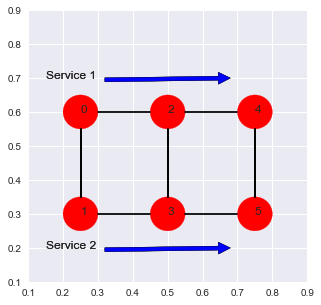

In [7]:
plt.figure(figsize=(5,5))
ax = plt.gca()
for i in xrange(2):
    for j in xrange(3):
        circle = plt.Circle((0.25*(j+1), 0.3*(i+1)), 0.05, color='r')
        ax.add_artist(circle)
        ax.annotate(str((1-i)+2*j), (0.25*(j+1), 0.3*(i+1)))
        plt.plot([0.25*(j+1), 0.25*(j+1)], [0.35, 0.55], color='k')
    plt.plot([0.3, 0.45], [0.3*(i+1), 0.3*(i+1)], color='k')
    plt.plot([0.55, 0.7], [0.3*(i+1), 0.3*(i+1)], color='k')
    ax.annotate('Service 1', xy=(0.7, 0.7), xytext=(0.15, 0.7), arrowprops=dict(facecolor='blue', shrink=0.05))
    ax.annotate('Service 2', xy=(0.7, 0.2), xytext=(0.15, 0.2), arrowprops=dict(facecolor='blue', shrink=0.05))
plt.xlim((0.1,0.9))
plt.ylim((0.1,0.9))

In [234]:
# Run simulation and plot simulation statistics
def test(N, t, deltar, costr, policy, V):
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' costr=' + str(costr)
    sim_command += ' policy=' + policy + ' V=' + str(V) + ' logging=false'
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_costr_' + str(costr)
    sim_instance += '_' + policy + '_V_' + str(V)

    commands.getstatusoutput(sim_command)    
    
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    cost = pd.DataFrame.from_csv(output_dir + 'cost_' + sim_instance + '.csv')

    
    for n in xrange(N):
        # Set the process cost as 0 when in reconfiguration
        cost.loc[schedule['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_px'] = 0

    for l in schedule.columns[['link' in x and 'rate' in x for x in schedule.columns]].str.strip('_rate'):
        # Set the transmission cost as 0 when in reconfiguration
        cost.loc[schedule[l+'_reconfig'] > 0, l+'_tx'] = 0

    
    node_rate_columns = schedule.columns[[('rate' in x and 'node' in x) for x in schedule.columns]]
    link_rate_columns = schedule.columns[[('rate' in x and 'link' in x) for x in schedule.columns]]
    #plt.figure()
    #schedule[node_rate_columns].head(1000).plot()
    plt.figure()
    fig, axes = plt.subplots(1, 4, figsize=(15, 4));
    schedule[node_rate_columns].mean().plot(kind='bar', ylim=[0,4], ax=axes[0])
    plt.title('V = ' + str(V))
    
    schedule[link_rate_columns].mean().plot(kind='bar', ylim=[0,4], ax=axes[1])
    
    queue.sum(axis=1).plot(ax=axes[2])
    
    cost.sum(axis=1).plot(ax=axes[3])
    
    print 'Mean queue length sum = ', queue.sum(axis=1)[(t/10):].mean()
    print 'Mean cost = ', cost.sum(axis=1)[(t/10):].mean()

    commands.getstatusoutput('rm ' + output_dir + 'schedule_' + sim_instance + '.csv')
    commands.getstatusoutput('rm ' + output_dir + 'queue_' + sim_instance + '.csv')
    commands.getstatusoutput('rm ' + output_dir + 'cost_' + sim_instance + '.csv')

    return schedule, queue, cost

## Adaptive DCNC with various parameter V

For the following simulations, we fix the duration of reconfiguration delay as $\Delta_r = 10$.

For each V, the subfigures indicate 

(a) mean process rate at each node (b) mean transmission rate at each link (c) evoluation of total queue length

In [235]:
N = 6
t = 300000
deltar = 10
costr = 0
V = 10.0
policy = 'ADCNC'

V =  1.0 , deltar =  1
Mean queue length sum =  298.481077778
Mean cost =  17.2633222222
V =  2.0 , deltar =  1
Mean queue length sum =  460.055244444
Mean cost =  15.7718777778
V =  10.0 , deltar =  1
Mean queue length sum =  1512.79203333
Mean cost =  15.3944962963
V =  20.0 , deltar =  1
Mean queue length sum =  2637.27645926
Mean cost =  15.3985148148
V =  100.0 , deltar =  1
Mean queue length sum =  11618.7248951
Mean cost =  15.387937037
V =  200.0 , deltar =  1
Mean queue length sum =  22834.2802173
Mean cost =  15.396491358
V =  500.0 , deltar =  1
Mean queue length sum =  56425.1760136
Mean cost =  15.398017284
V =  1000.0 , deltar =  1
Mean queue length sum =  112452.548308
Mean cost =  15.4046588477
V =  1.0 , deltar =  5
Mean queue length sum =  1161.79148889
Mean cost =  22.8957111111
V =  2.0 , deltar =  5
Mean queue length sum =  1283.13013333
Mean cost =  21.0284777778
V =  10.0 , deltar =  5
Mean queue length sum =  2477.23944444
Mean cost =  16.3991
V =  20.0 , deltar

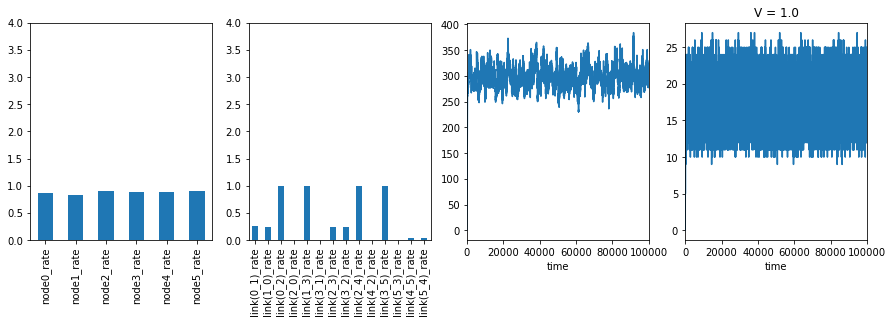

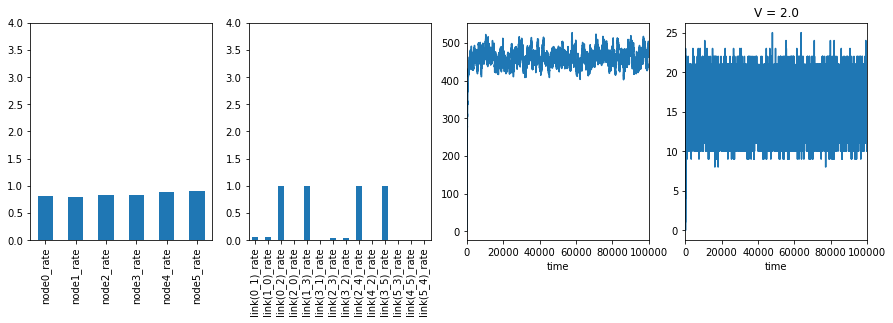

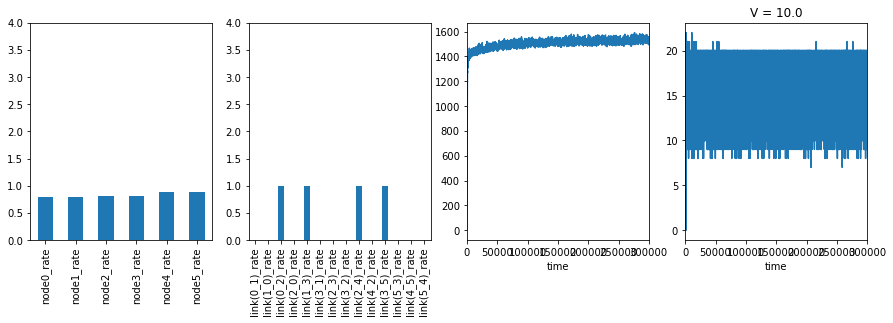

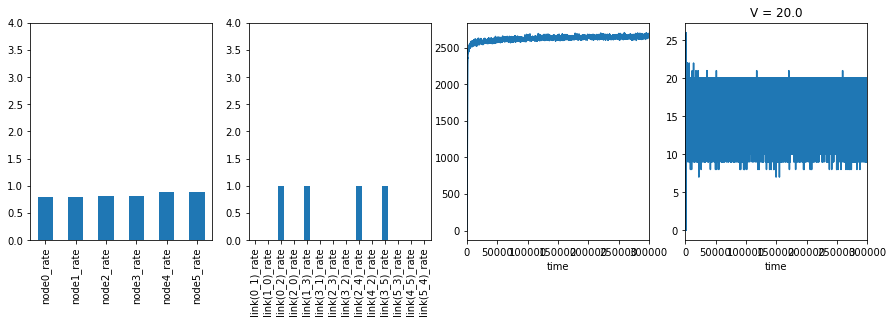

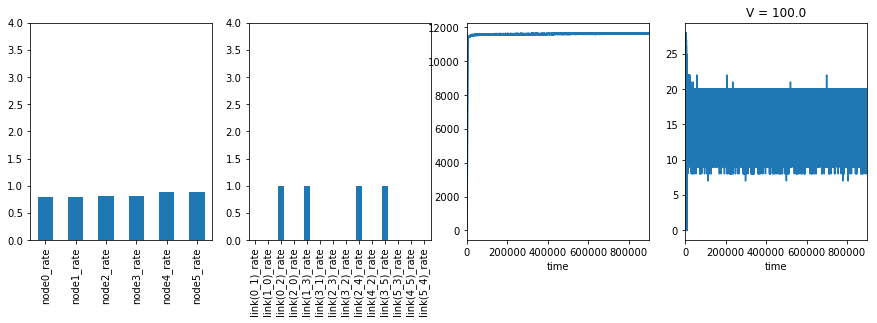

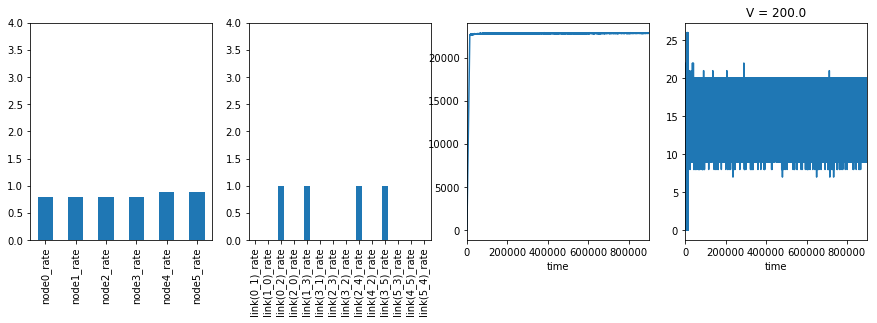

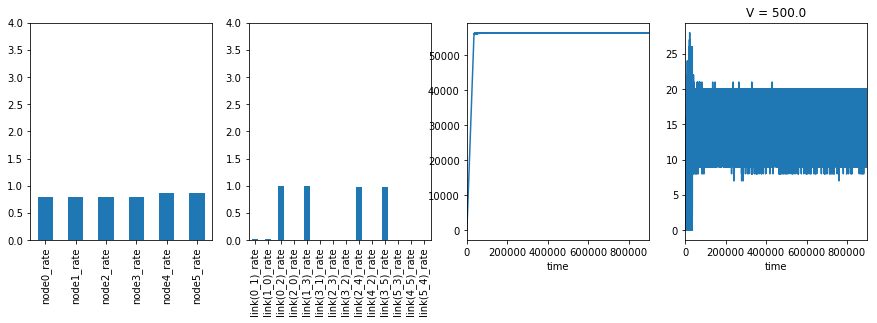

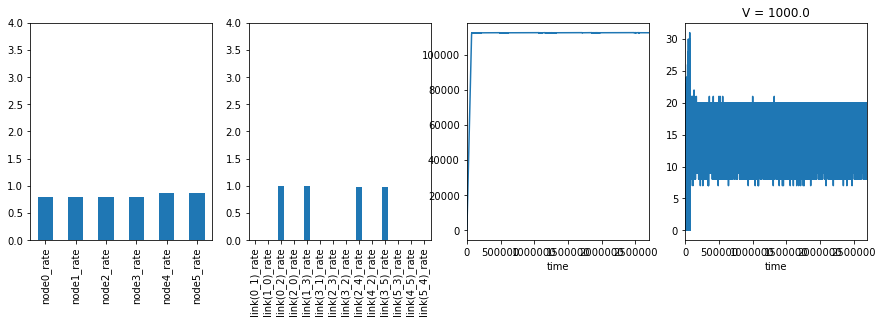

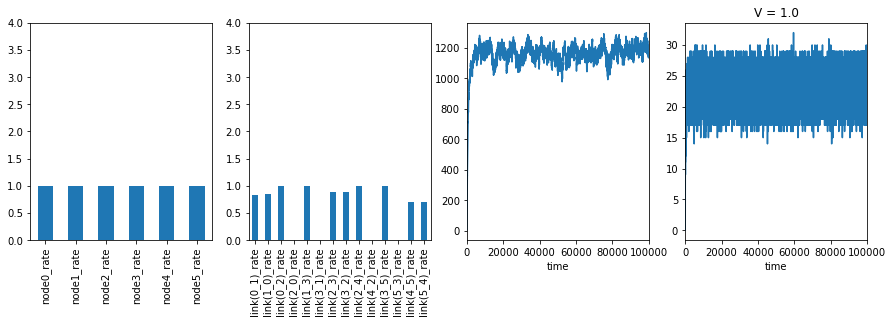

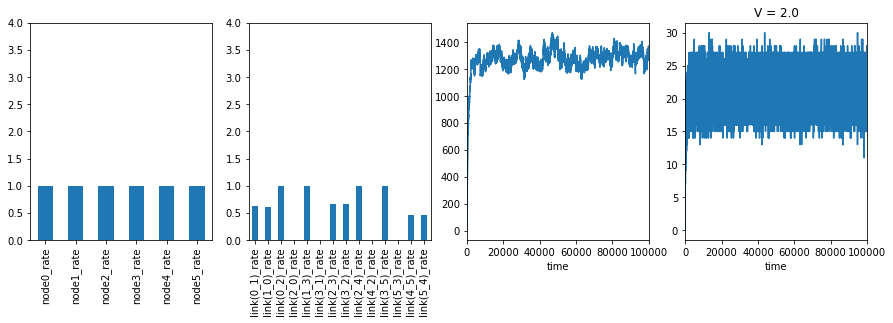

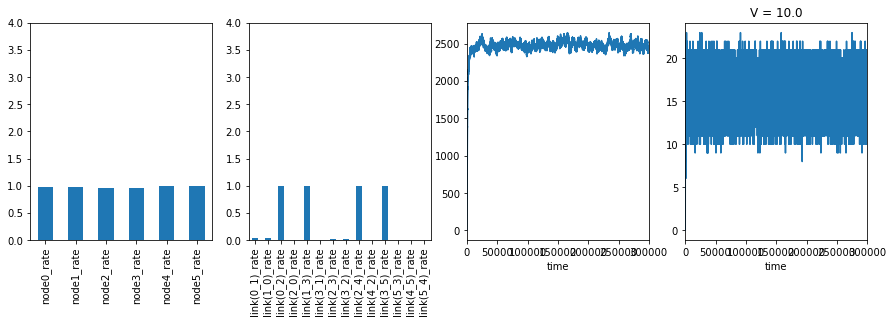

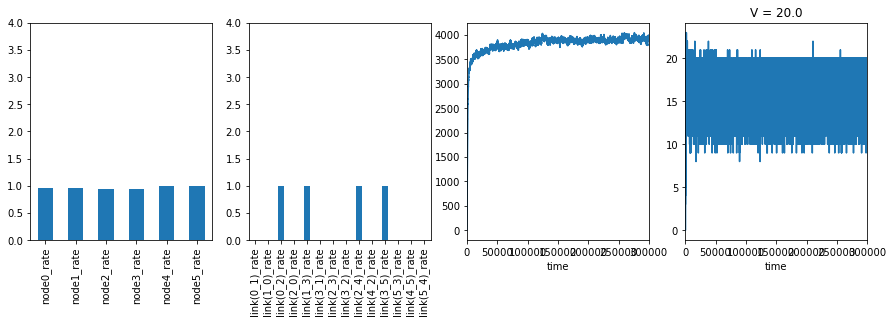

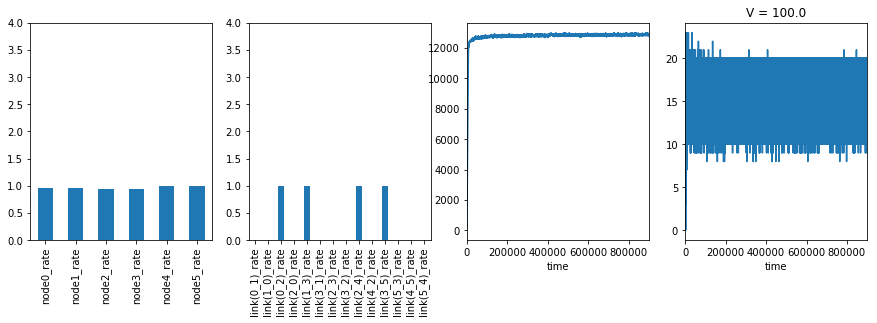

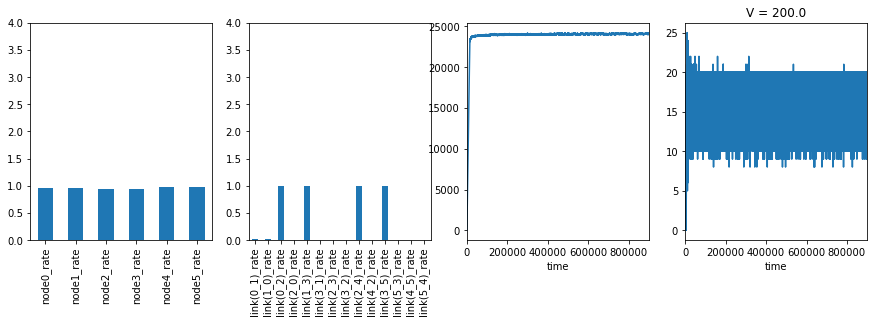

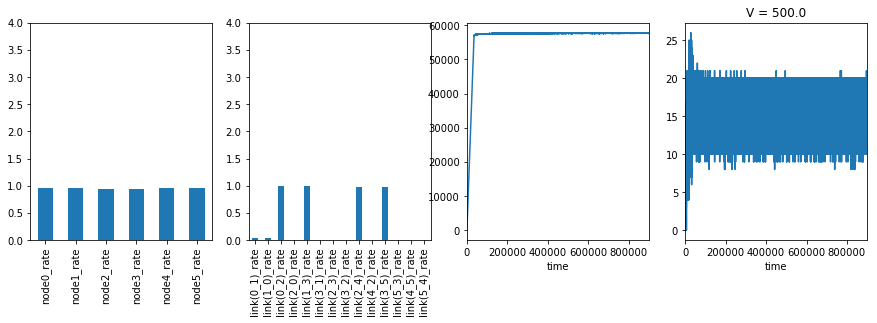

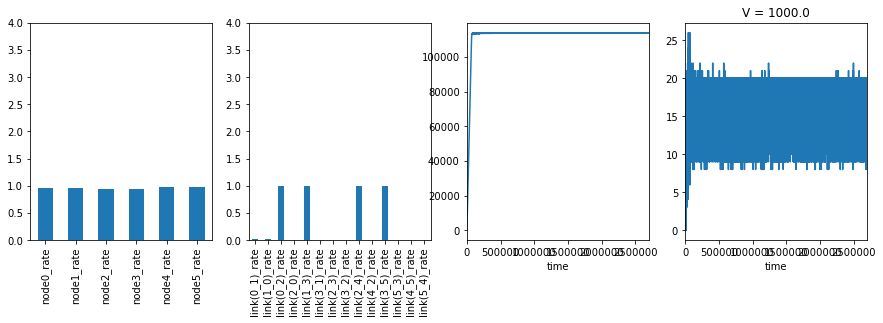

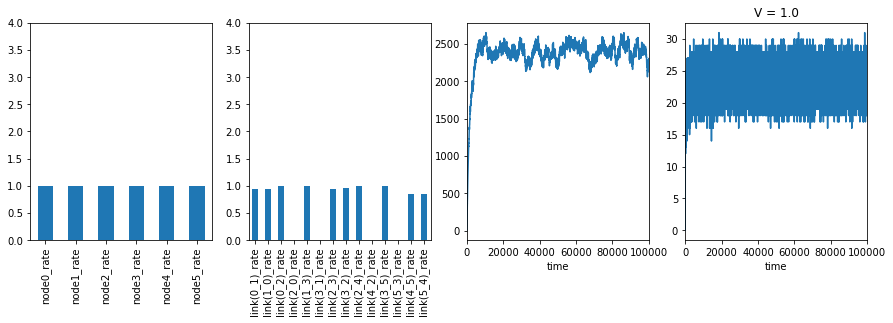

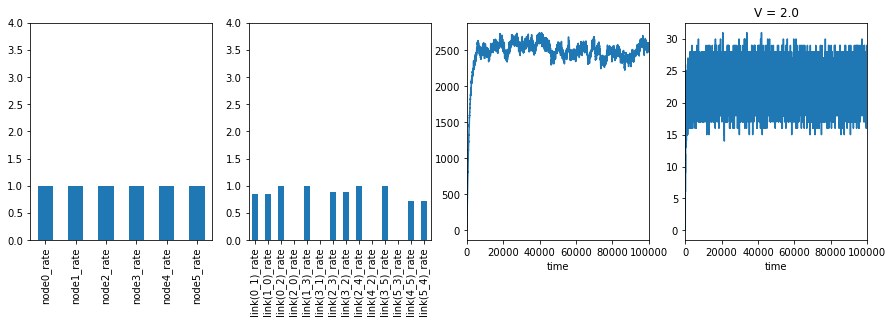

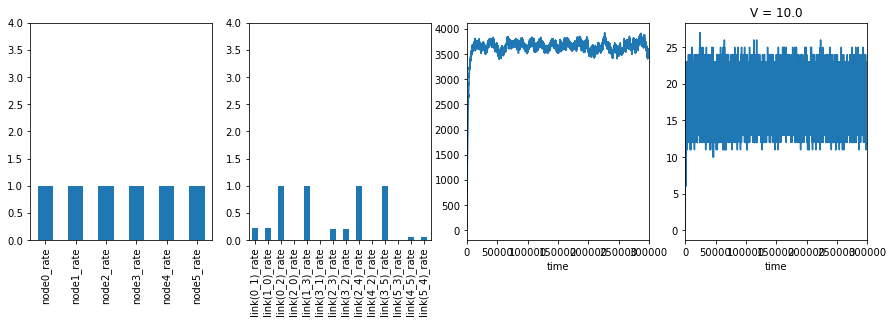

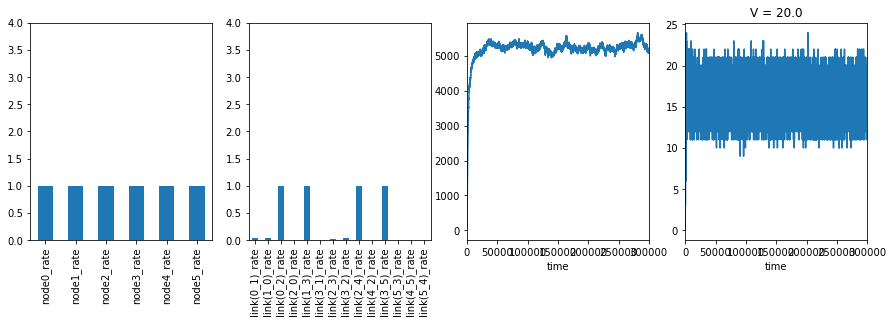

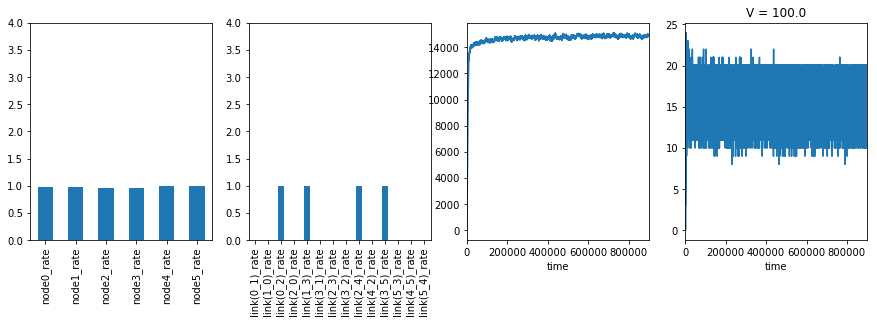

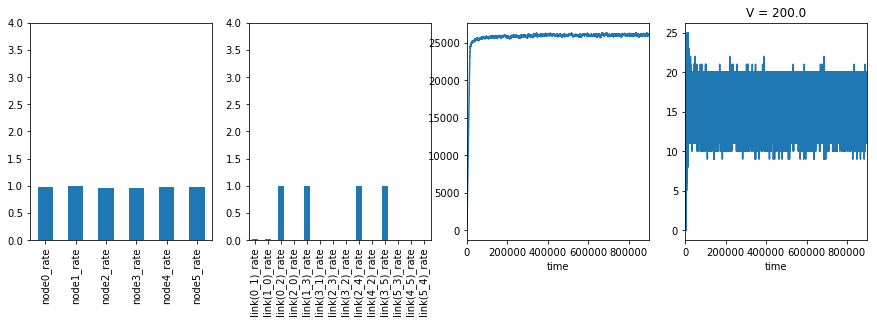

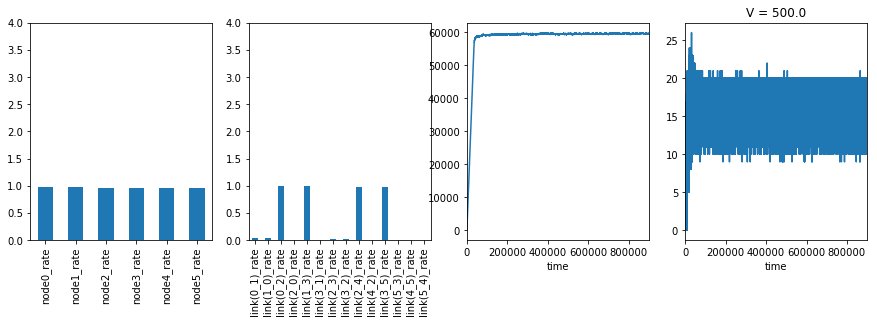

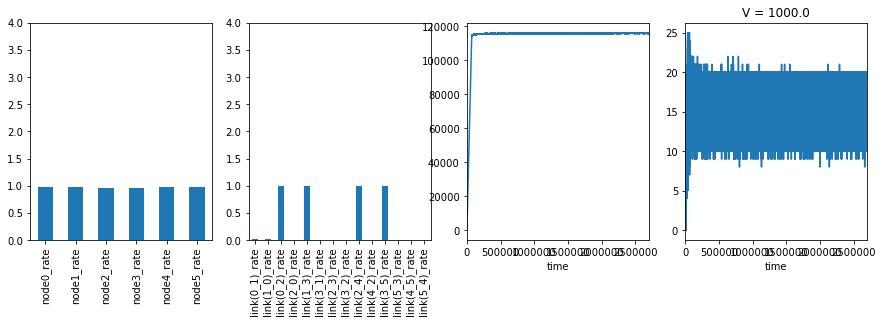

In [236]:
deltars = [1, 5, 10]
deltar_costs = []
deltar_queues = []
for deltar in deltars:
    costs = []
    queues = []
    #Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    Vs = [1.0, 2.0, 10.0, 20.0, 100.0, 200.0, 500.0, 1000.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1)[t/5:].mean())
        queues.append(queue.sum(axis=1)[t/5:].mean())
        del schedule, queue, cost
    
    deltar_costs.append(costs)
    deltar_queues.append(queues)

#### Cost - Delay tradeoff with varying V

In the following figures, we show the mean costs and the mean total queue lengths with varying V.

From the figures below, we could observe the cost-delay tradeoff under various paramter V.

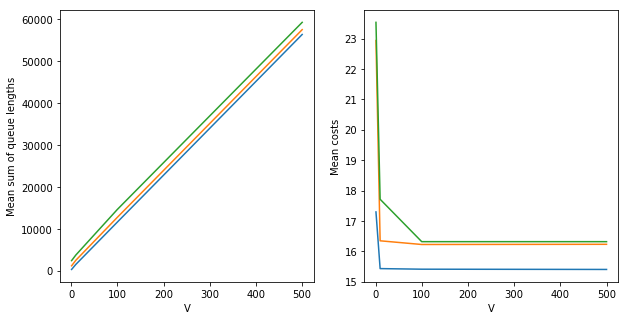

In [230]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for queues in deltar_queues:
    plt.plot(Vs, queues)
    plt.xlabel('V')
    plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
for costs in deltar_costs:
    plt.plot(Vs, costs)
    plt.xlabel('V')
    plt.ylabel('Mean costs')

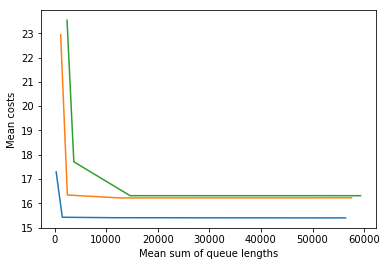

In [233]:
plt.figure()
for i in xrange(len(deltars)):
    plt.plot(deltar_queues[i], deltar_costs[i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')
    
#plt.ylim([0,100])

In [237]:
data_rate_0_8 = {'deltar_queues': deltar_queues, 'deltar_costs': deltar_costs}

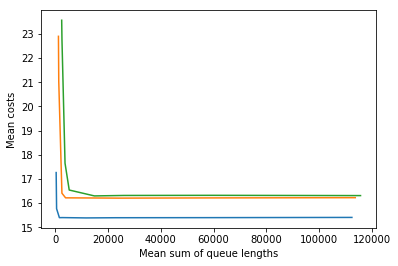

In [257]:
plt.figure()
for i in xrange(len(deltars)):
    plt.plot(data_rate_0_8['deltar_queues'][i], data_rate_0_8['deltar_costs'][i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')
    
#plt.ylim([0,30])

In [238]:
def changeRate(rate):
    flowWrite = open('input/temp_flow.in', 'w')
    with open('input/flow.in', 'r') as flowFile:
        for line in flowFile:
            flow = line.split(',')
            flow[-1] = str(rate)
            flowWrite.write(','.join(flow) + '\n')
    flowWrite.close()
    commands.getstatusoutput('mv input/temp_flow.in input/flow.in')

In [239]:
changeRate(0.5)

V =  1.0 , deltar =  1
Mean queue length sum =  187.038144444
Mean cost =  11.75
V =  2.0 , deltar =  1
Mean queue length sum =  356.095877778
Mean cost =  11.4697666667
V =  10.0 , deltar =  1
Mean queue length sum =  1263.10275185
Mean cost =  11.4863555556
V =  20.0 , deltar =  1
Mean queue length sum =  2377.85057037
Mean cost =  11.4988444444
V =  100.0 , deltar =  1
Mean queue length sum =  11354.8667815
Mean cost =  11.4696185185
V =  200.0 , deltar =  1
Mean queue length sum =  22555.2374568
Mean cost =  11.470162963
V =  500.0 , deltar =  1
Mean queue length sum =  56157.9056321
Mean cost =  11.4785160494
V =  1000.0 , deltar =  1
Mean queue length sum =  112167.483315
Mean cost =  11.4825604938
V =  1.0 , deltar =  5
Mean queue length sum =  514.158744444
Mean cost =  18.3327444444
V =  2.0 , deltar =  5
Mean queue length sum =  641.006888889
Mean cost =  15.4281666667
V =  10.0 , deltar =  5
Mean queue length sum =  1753.84681481
Mean cost =  13.4855444444
V =  20.0 , deltar

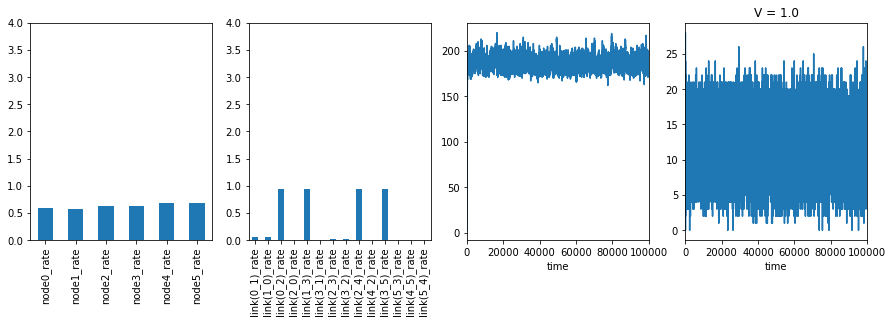

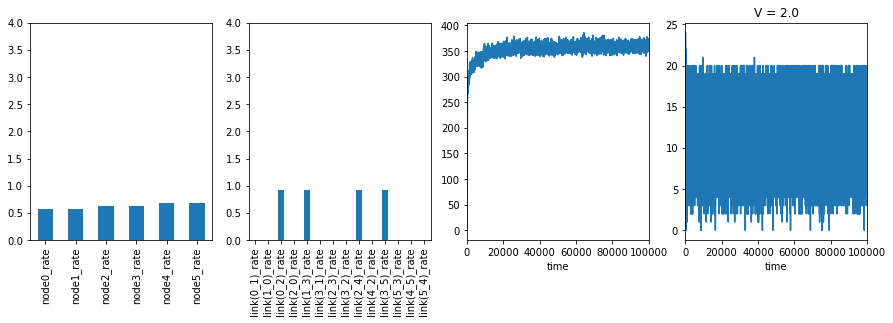

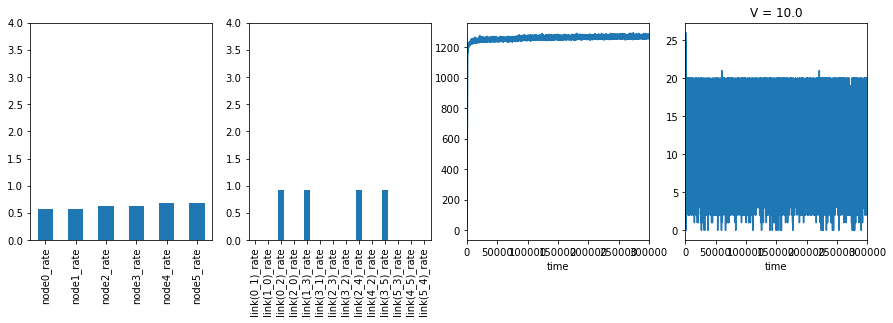

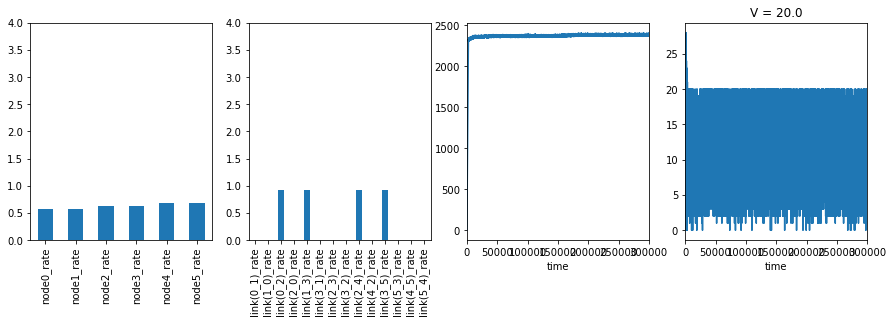

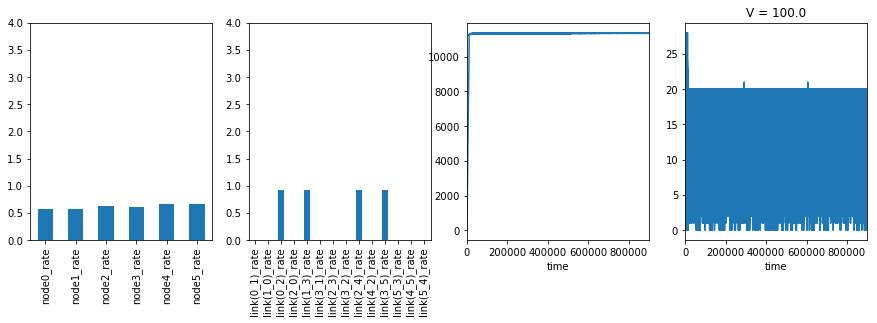

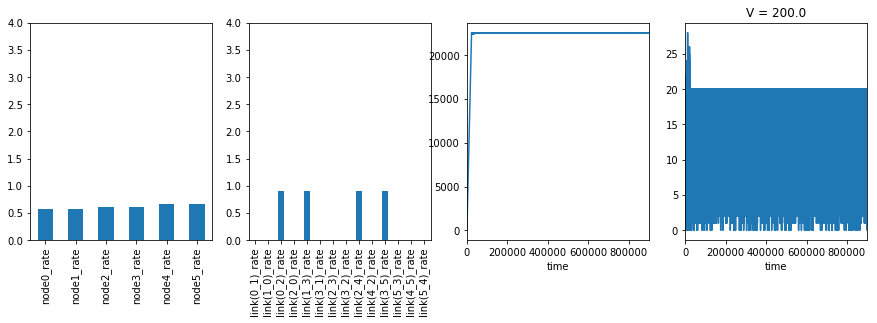

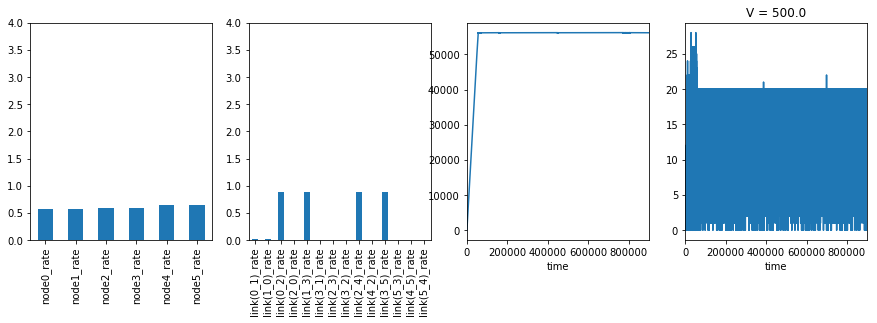

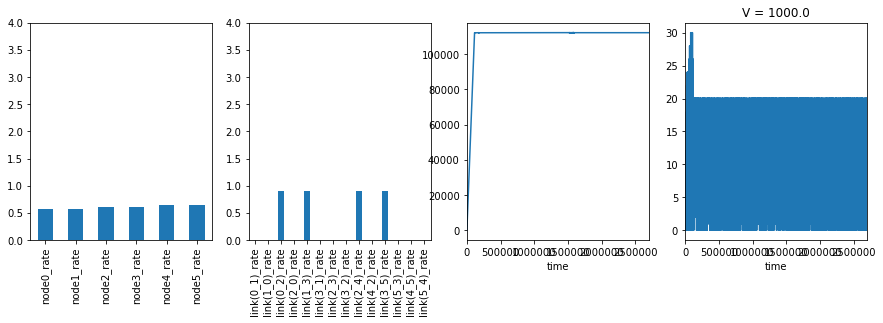

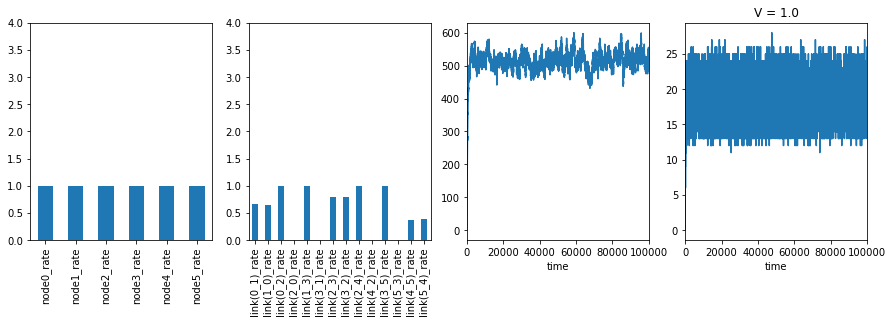

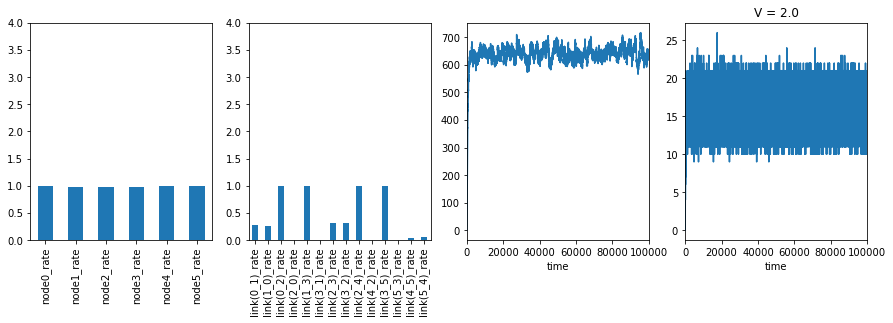

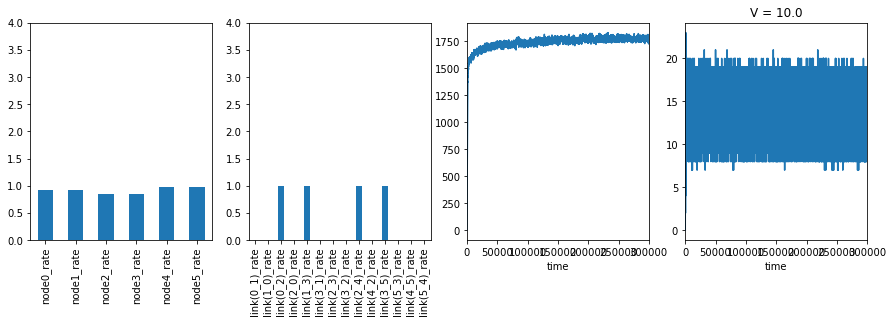

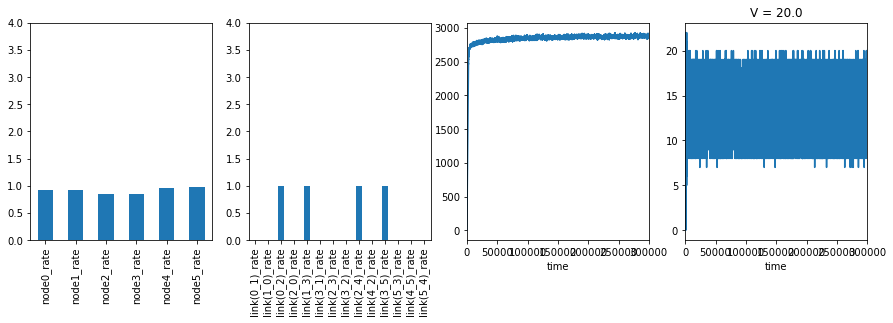

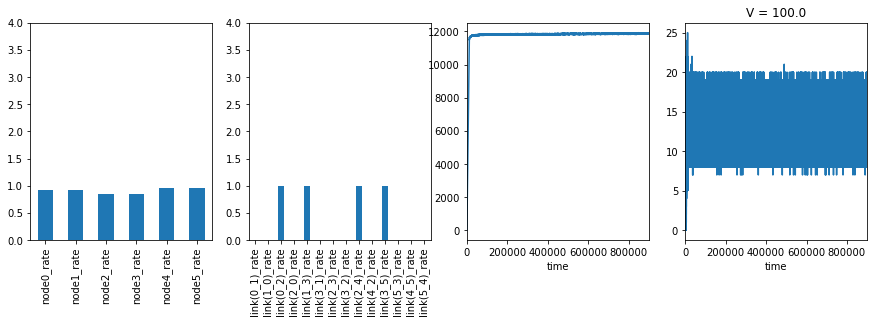

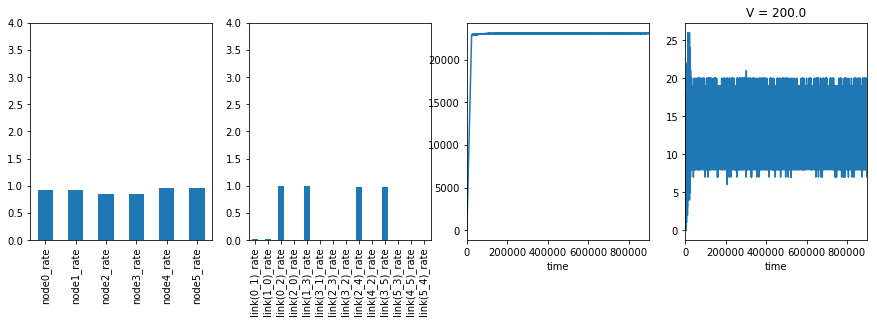

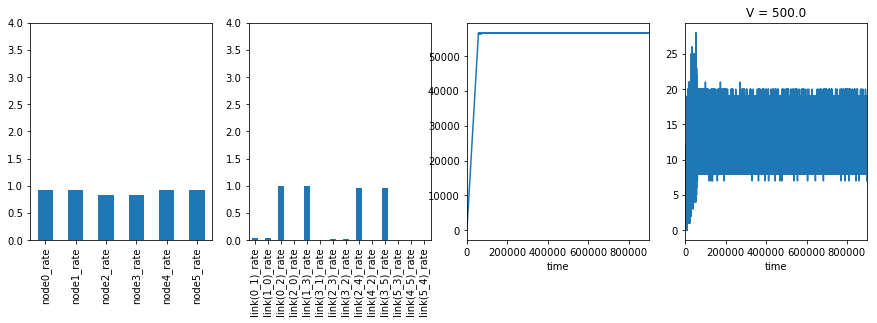

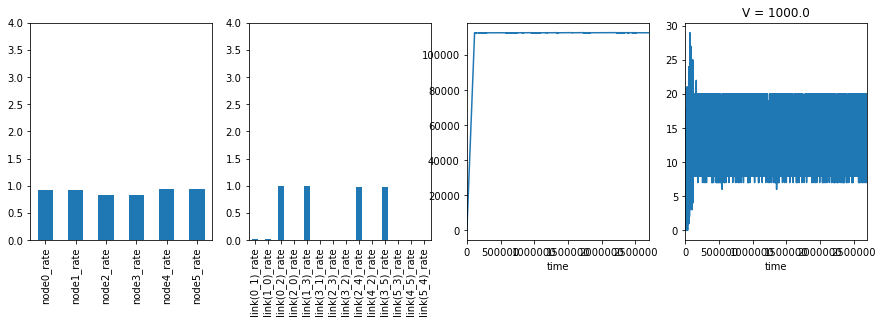

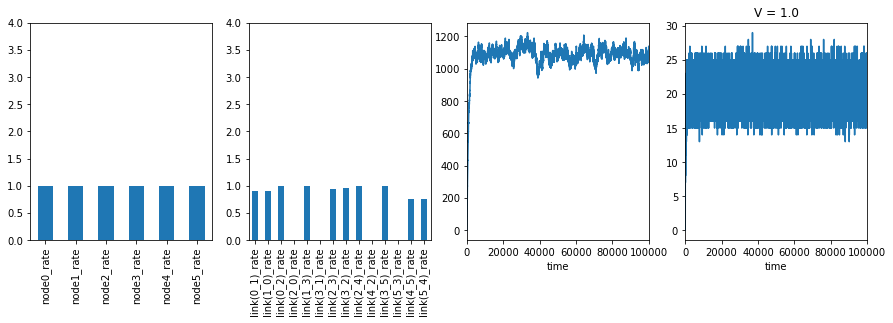

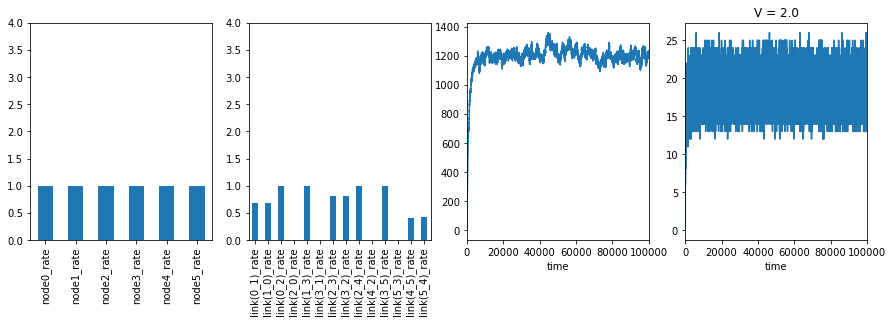

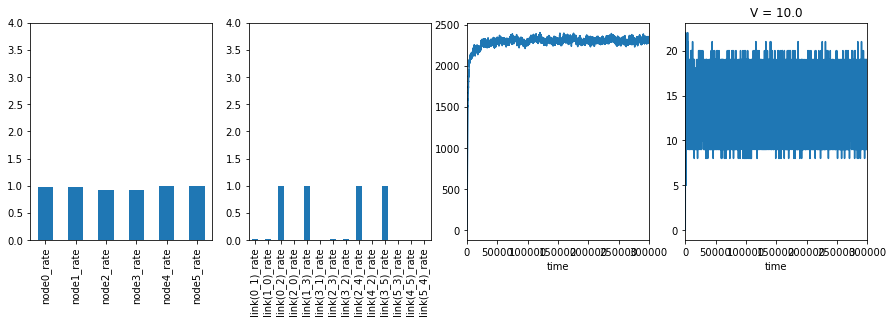

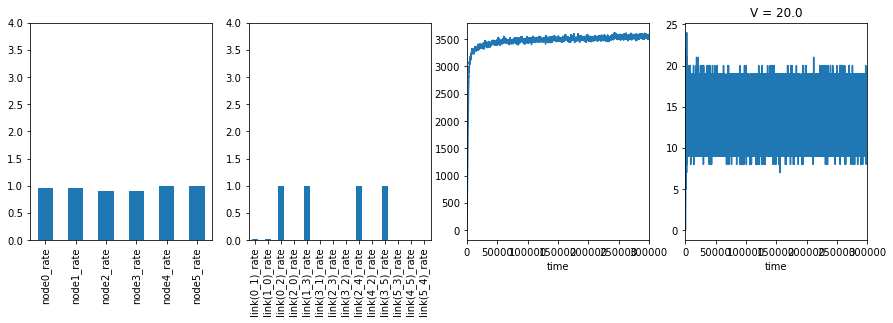

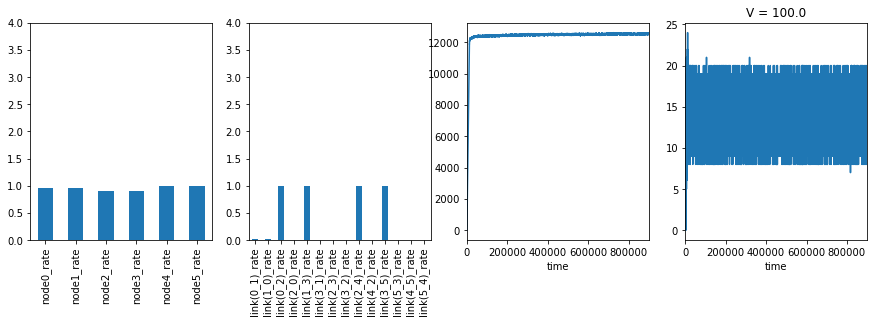

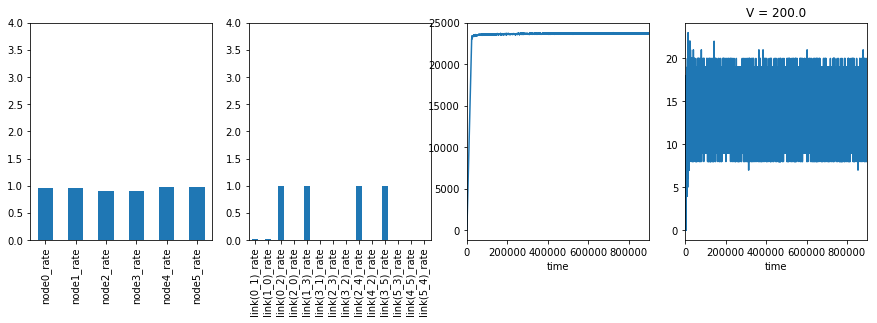

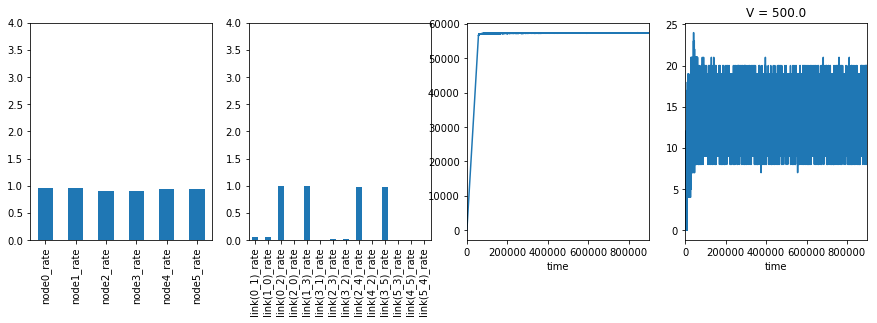

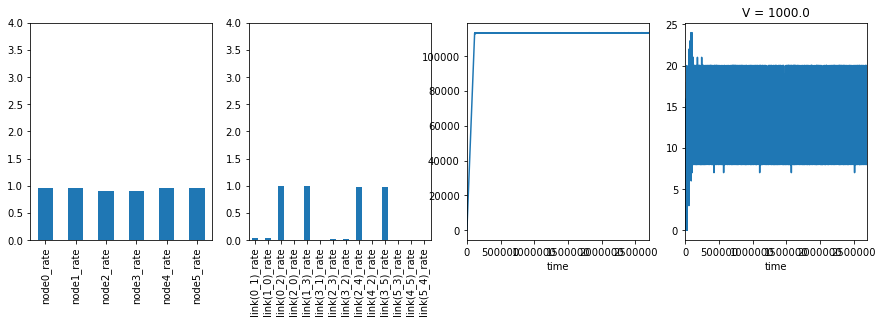

In [240]:
deltars = [1, 5, 10]
deltar_costs = []
deltar_queues = []
for deltar in deltars:
    costs = []
    queues = []
    #Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    Vs = [1.0, 2.0, 10.0, 20.0, 100.0, 200.0, 500.0, 1000.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1)[t/5:].mean())
        queues.append(queue.sum(axis=1)[t/5:].mean())
        del schedule, queue, cost
    
    deltar_costs.append(costs)
    deltar_queues.append(queues)

In [241]:
data_rate_0_5 = {'deltar_queues': deltar_queues, 'deltar_costs': deltar_costs}

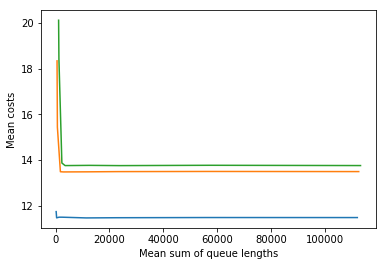

In [253]:
plt.figure()
for i in xrange(len(deltars)):
    plt.plot(data_rate_0_5['deltar_queues'][i], data_rate_0_5['deltar_costs'][i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')
    
#plt.ylim([0,100])

In [242]:
changeRate(0.2)

V =  1.0 , deltar =  1
Mean queue length sum =  159.857066667
Mean cost =  4.76592222222
V =  2.0 , deltar =  1
Mean queue length sum =  278.472511111
Mean cost =  4.74803333333
V =  10.0 , deltar =  1
Mean queue length sum =  1183.11228889
Mean cost =  4.7299037037
V =  20.0 , deltar =  1
Mean queue length sum =  2302.83448889
Mean cost =  4.73447037037
V =  100.0 , deltar =  1
Mean queue length sum =  11267.196358
Mean cost =  4.7170037037
V =  200.0 , deltar =  1
Mean queue length sum =  22471.9143309
Mean cost =  4.71369012346
V =  500.0 , deltar =  1
Mean queue length sum =  55462.3477741
Mean cost =  4.56736666667
V =  1000.0 , deltar =  1
Mean queue length sum =  112064.187655
Mean cost =  4.70362633745
V =  1.0 , deltar =  5
Mean queue length sum =  200.259488889
Mean cost =  10.1785888889
V =  2.0 , deltar =  5
Mean queue length sum =  366.789222222
Mean cost =  9.68158888889
V =  10.0 , deltar =  5
Mean queue length sum =  1271.85297407
Mean cost =  9.67612962963
V =  20.0 , 

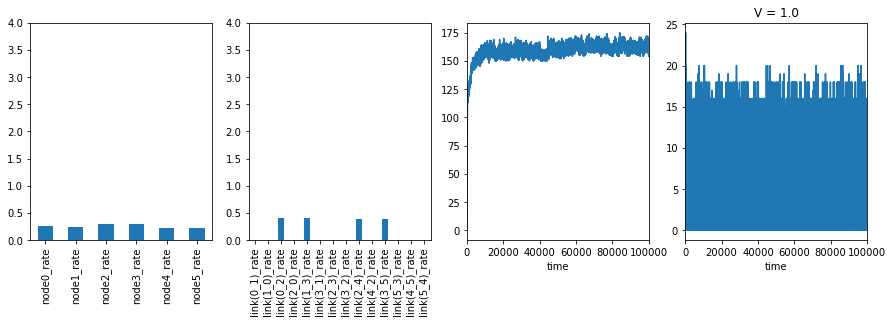

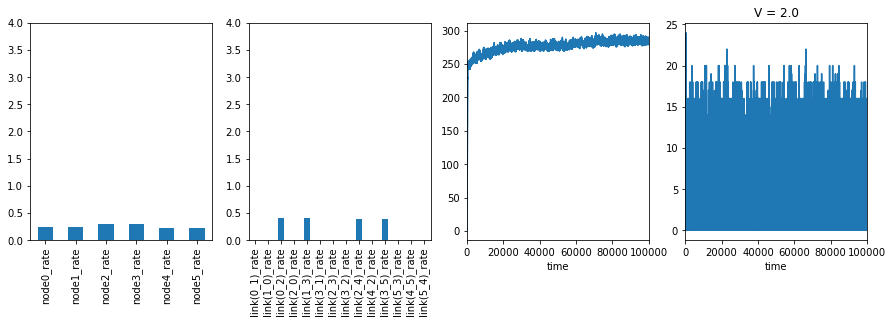

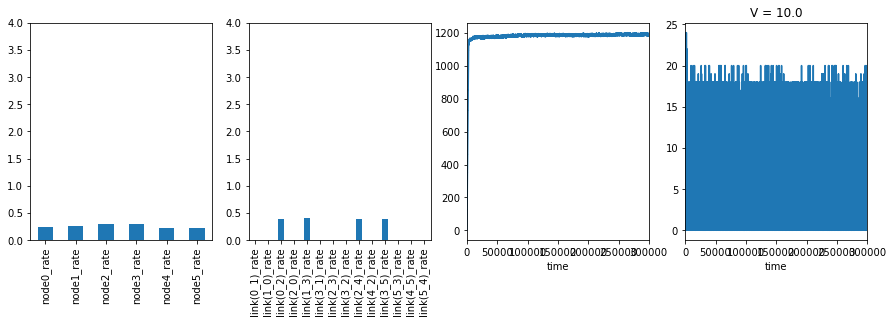

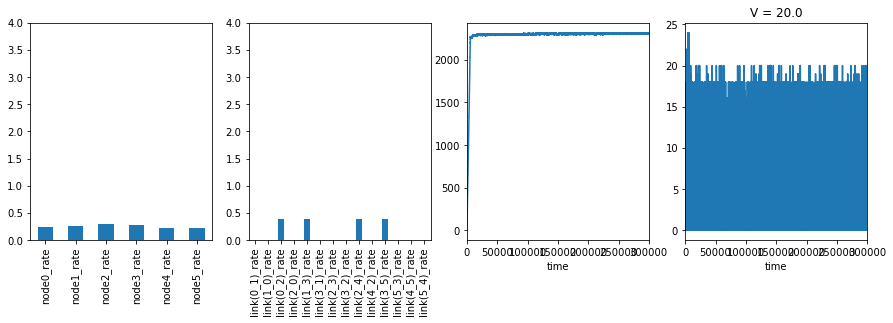

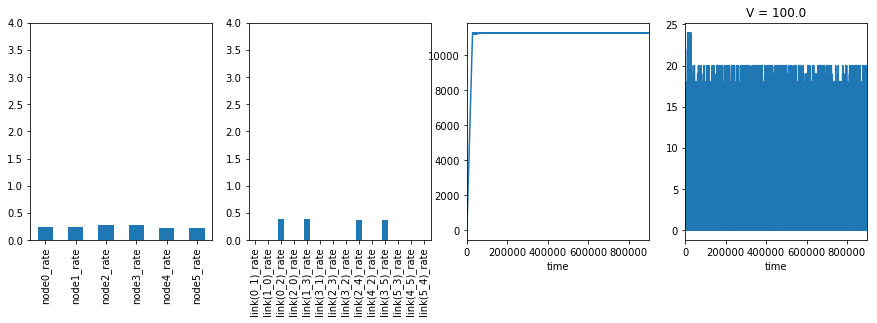

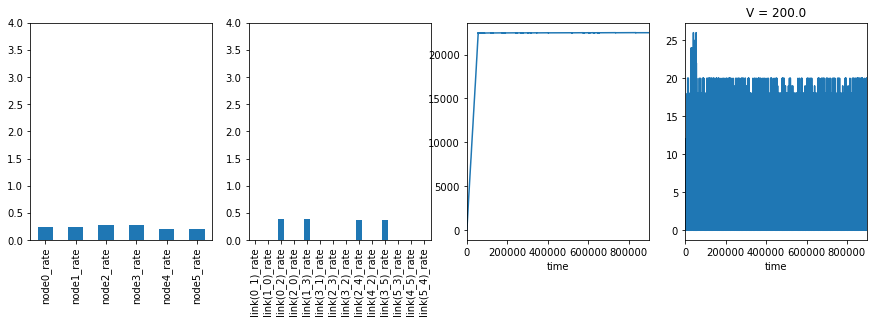

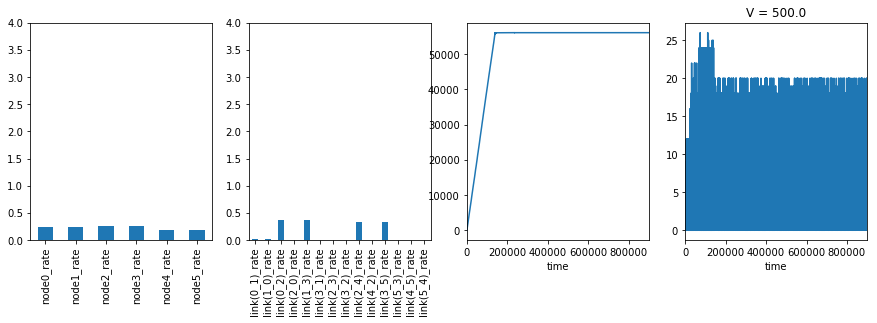

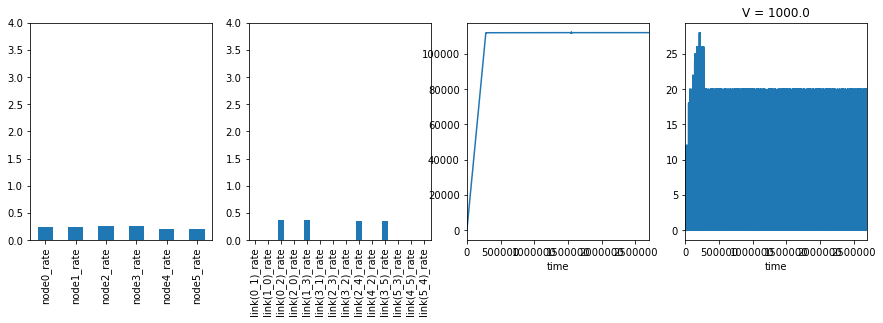

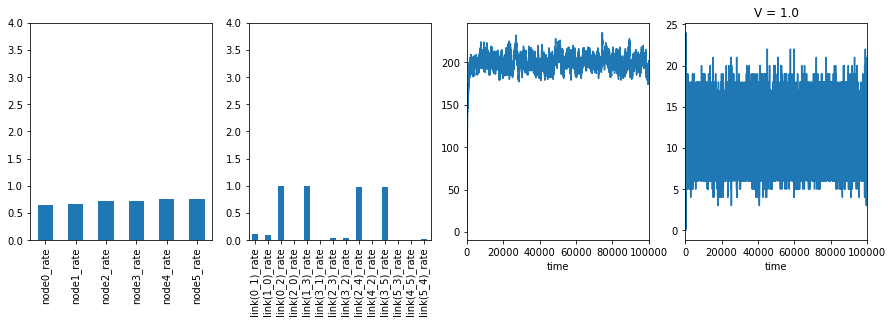

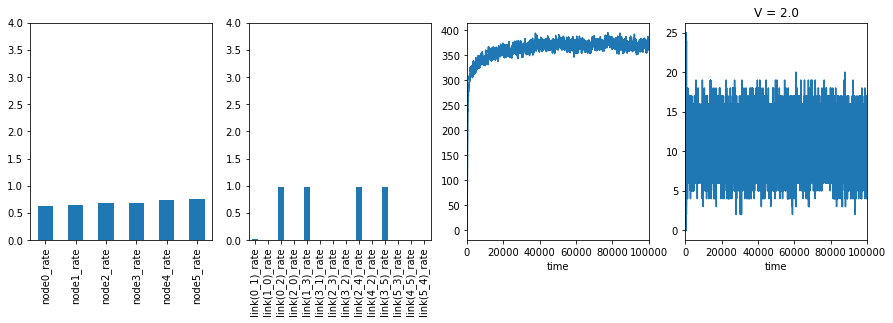

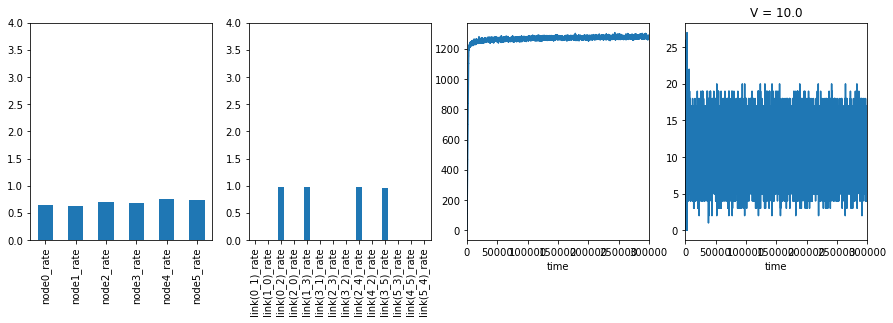

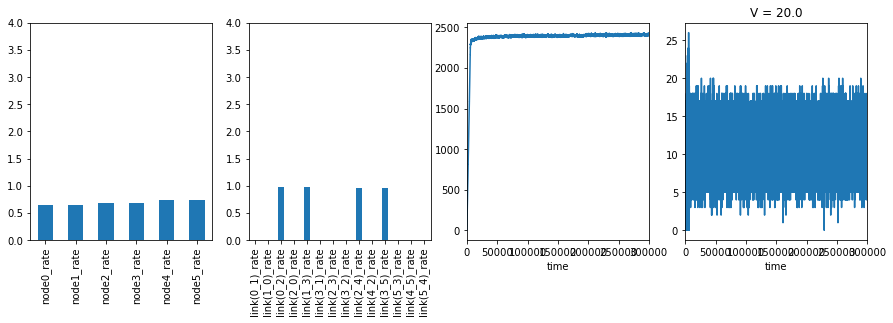

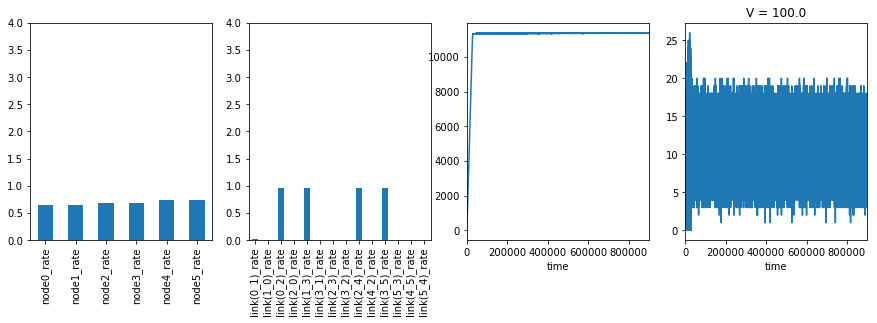

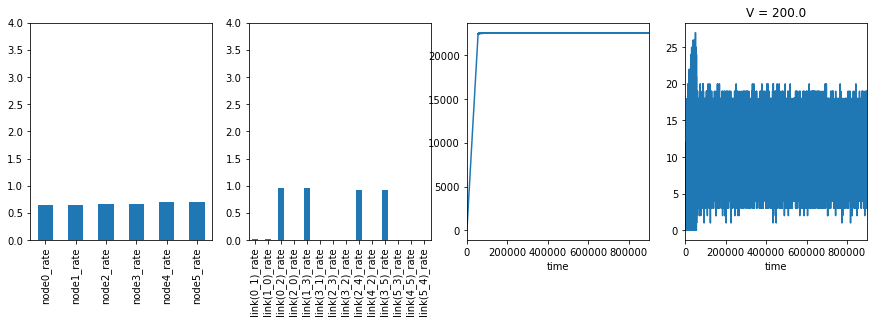

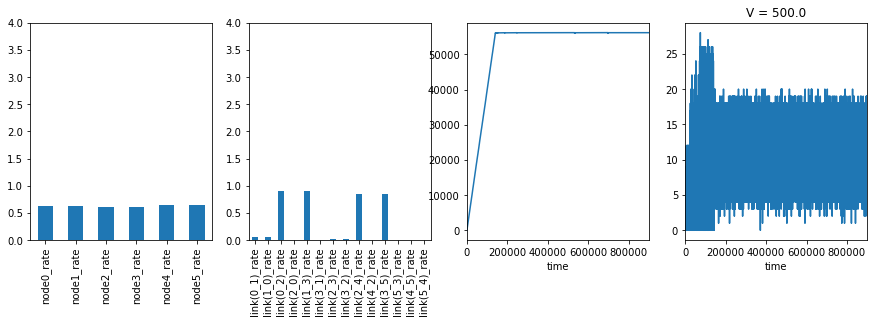

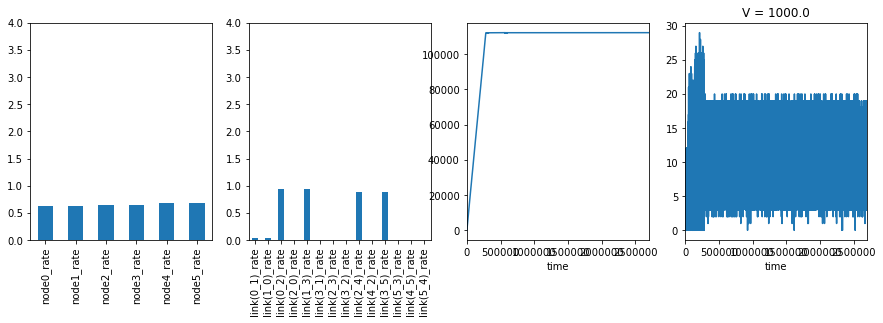

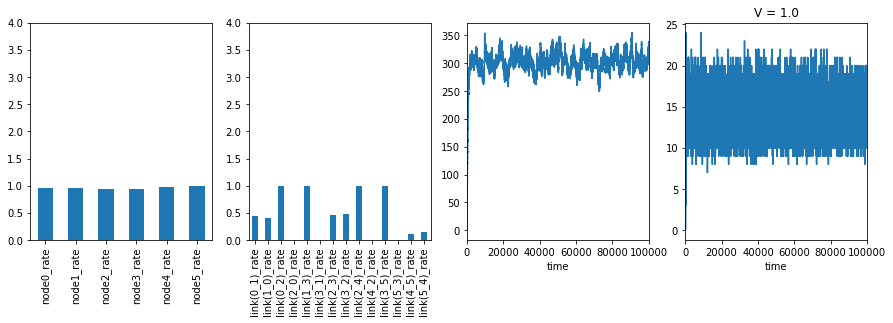

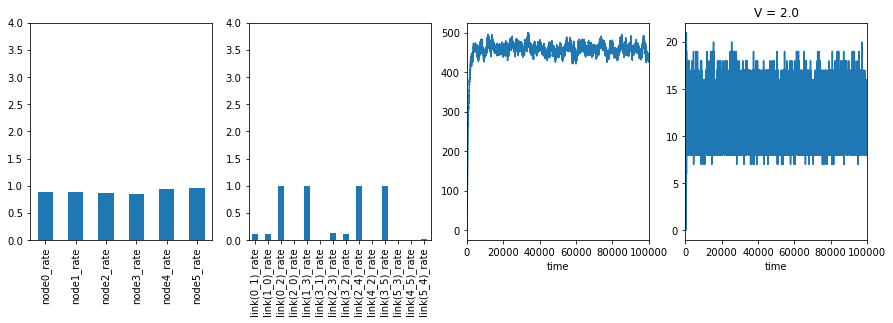

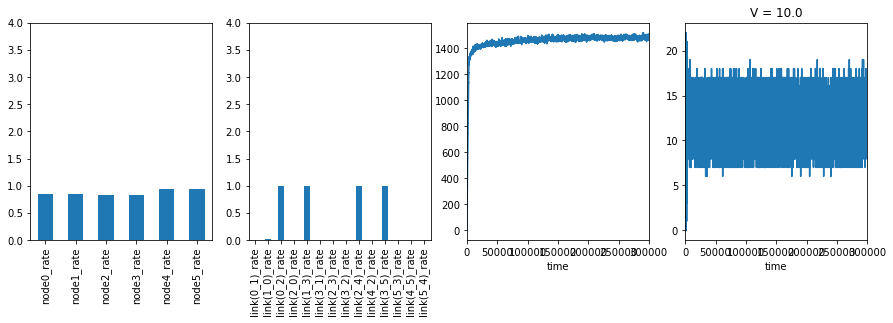

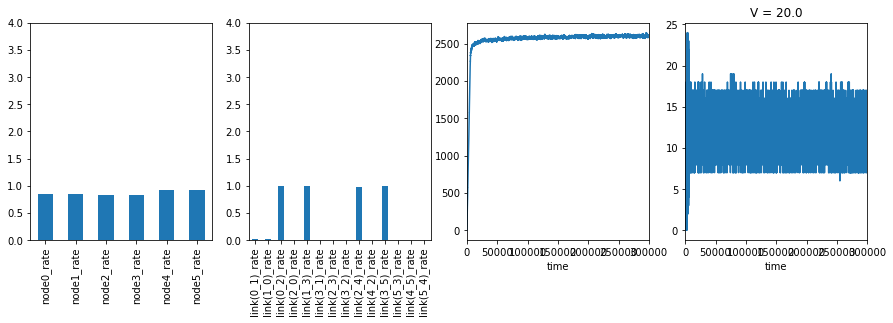

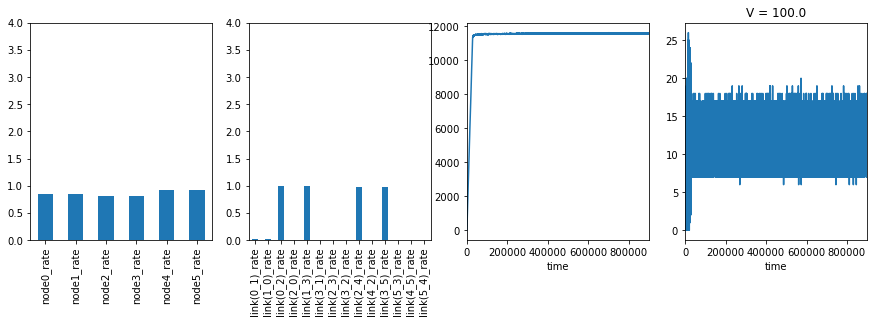

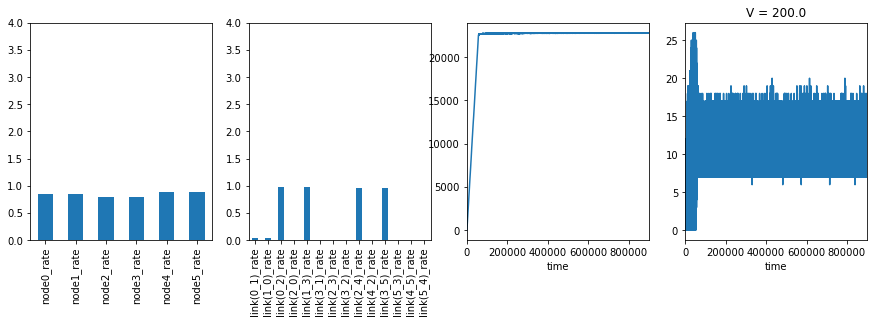

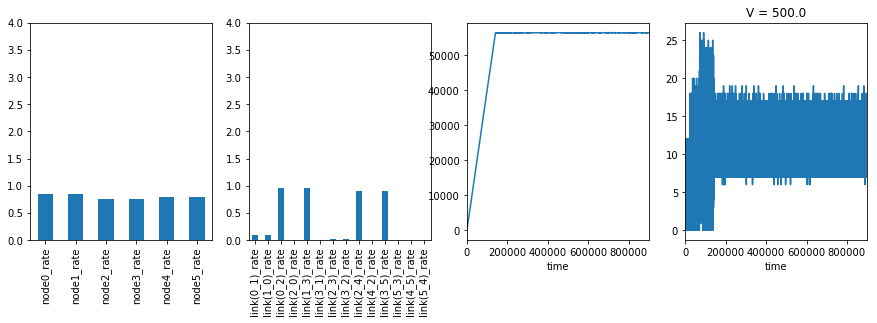

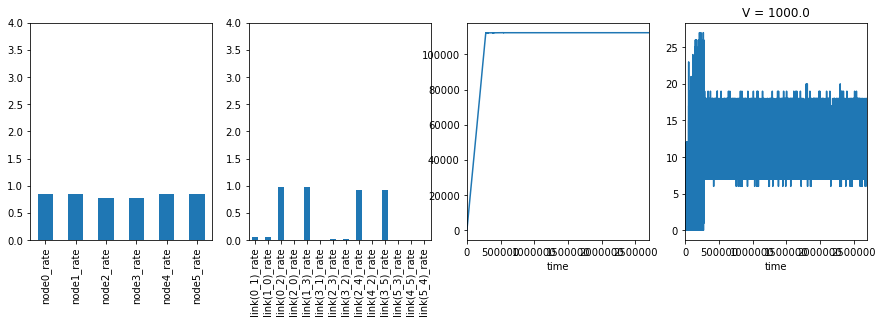

In [243]:
deltars = [1, 5, 10]
deltar_costs = []
deltar_queues = []
for deltar in deltars:
    costs = []
    queues = []
    #Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    Vs = [1.0, 2.0, 10.0, 20.0, 100.0, 200.0, 500.0, 1000.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1)[t/5:].mean())
        queues.append(queue.sum(axis=1)[t/5:].mean())
        del schedule, queue, cost
    
    deltar_costs.append(costs)
    deltar_queues.append(queues)

In [244]:
data_rate_0_2 = {'deltar_queues': deltar_queues, 'deltar_costs': deltar_costs}

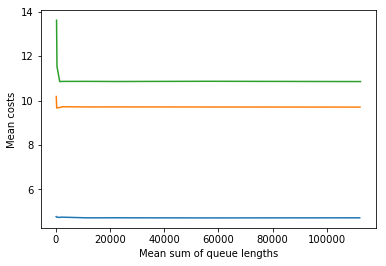

In [254]:
plt.figure()
for i in xrange(len(deltars)):
    plt.plot(data_rate_0_2['deltar_queues'][i], data_rate_0_2['deltar_costs'][i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')
    
#plt.ylim([0,100])

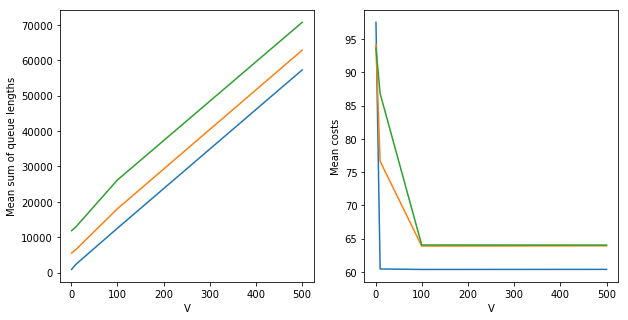

In [220]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for queues in deltar_queues:
    plt.plot(Vs, queues)
    plt.xlabel('V')
    plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
for costs in deltar_costs:
    plt.plot(Vs, costs)
    plt.xlabel('V')
    plt.ylabel('Mean costs')

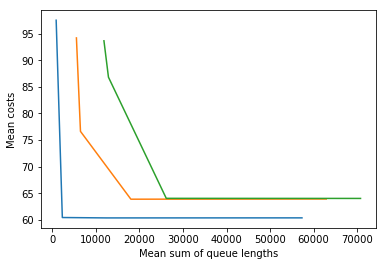

In [225]:
plt.figure()
for i in xrange(len(deltars)):
    plt.plot(deltar_queues[i], deltar_costs[i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')
    
#plt.ylim([0,100])

## Reconfiguration Costs

#### DCNC

In [24]:
N = 6
t = 300000
deltar = 0
costr = 10
V = 10.0
policy = 'DCNC'

V =  1.0 , deltar =  0 , costr =  0
Mean queue length sum =  268.5238
Mean cost =  183.277755556
V =  2.0 , deltar =  0 , costr =  0
Mean queue length sum =  331.065644444
Mean cost =  39.1284555556
V =  5.0 , deltar =  0 , costr =  0
Mean queue length sum =  968.715455556
Mean cost =  36.5299222222
V =  10.0 , deltar =  0 , costr =  0
Mean queue length sum =  1902.07562963
Mean cost =  36.0834592593
V =  20.0 , deltar =  0 , costr =  0
Mean queue length sum =  3770.18993333
Mean cost =  36.1099333333
V =  50.0 , deltar =  0 , costr =  0
Mean queue length sum =  9095.62332593
Mean cost =  36.0182
V =  100.0 , deltar =  0 , costr =  0
Mean queue length sum =  18179.8509049
Mean cost =  36.0229901235
V =  200.0 , deltar =  0 , costr =  0
Mean queue length sum =  33452.3994691
Mean cost =  36.0024777778
V =  1.0 , deltar =  0 , costr =  50
Mean queue length sum =  266.873311111
Mean cost =  841.524111111
V =  2.0 , deltar =  0 , costr =  50
Mean queue length sum =  331.475177778
Mean cost

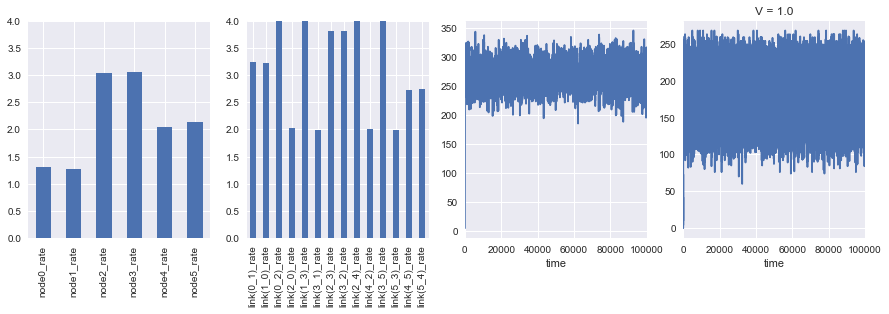

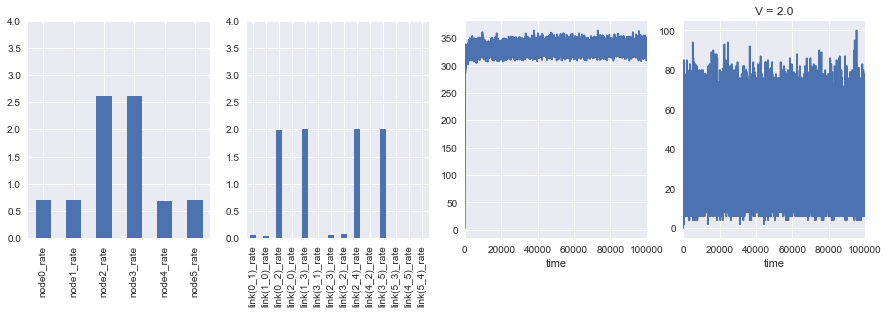

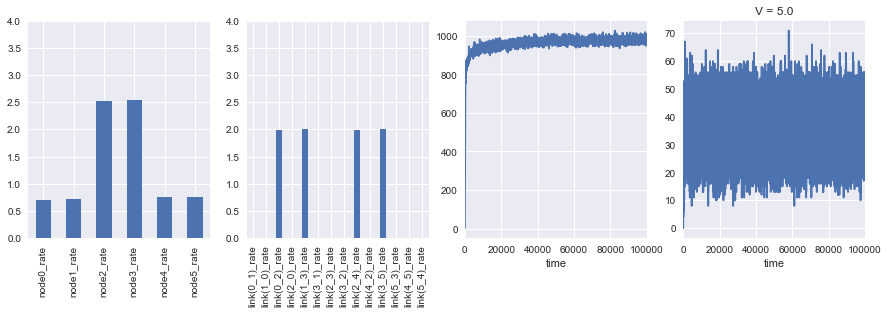

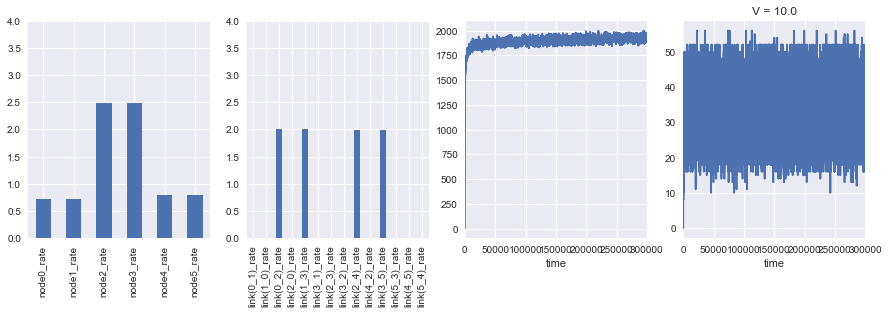

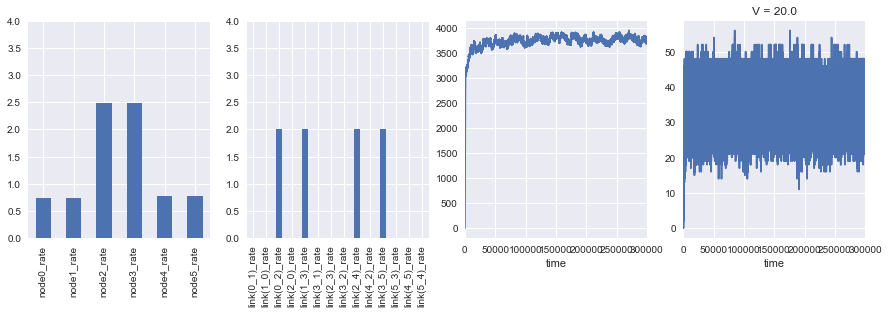

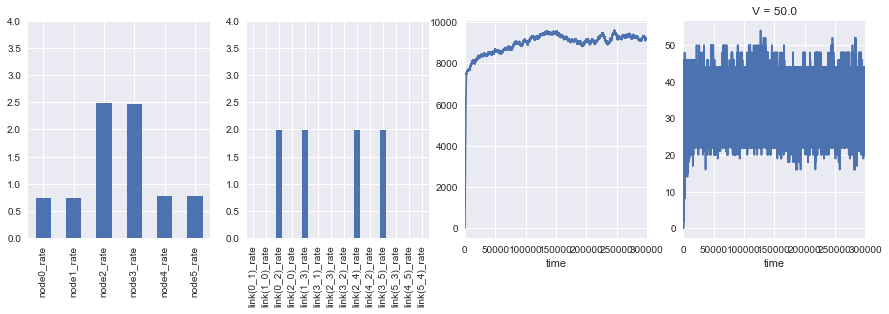

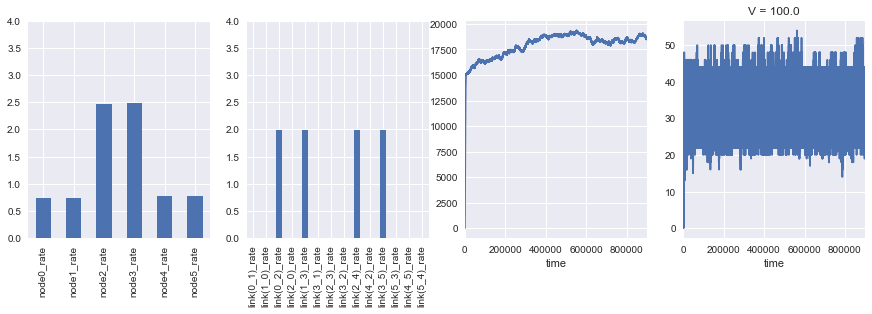

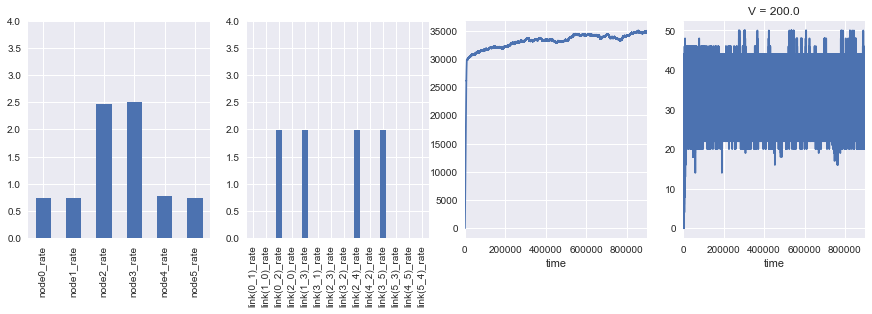

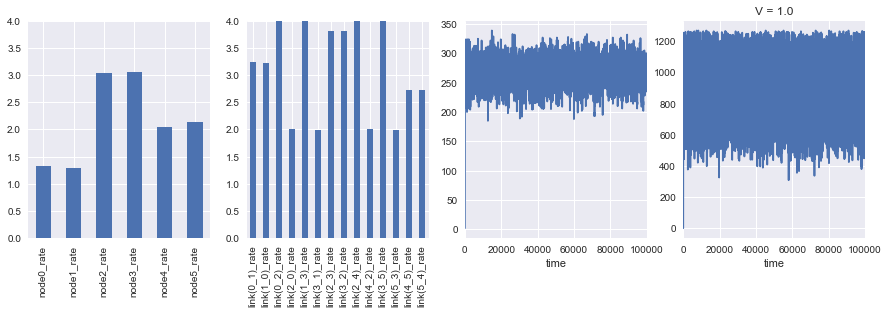

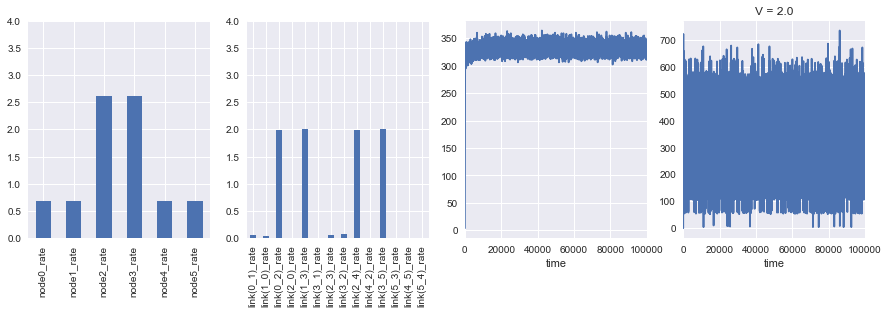

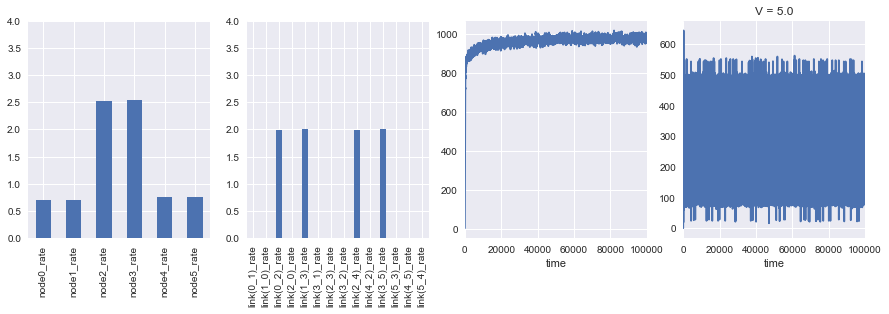

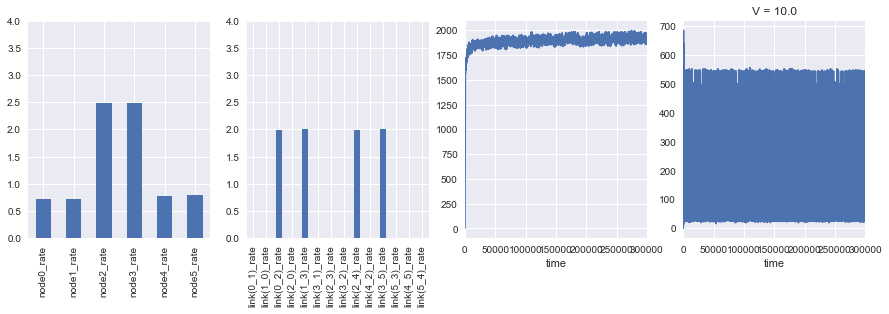

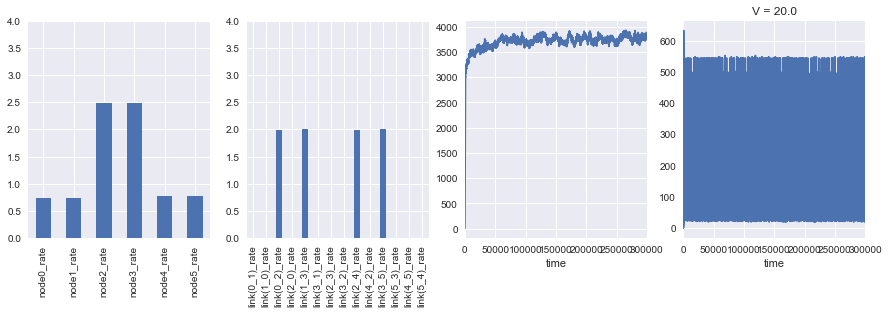

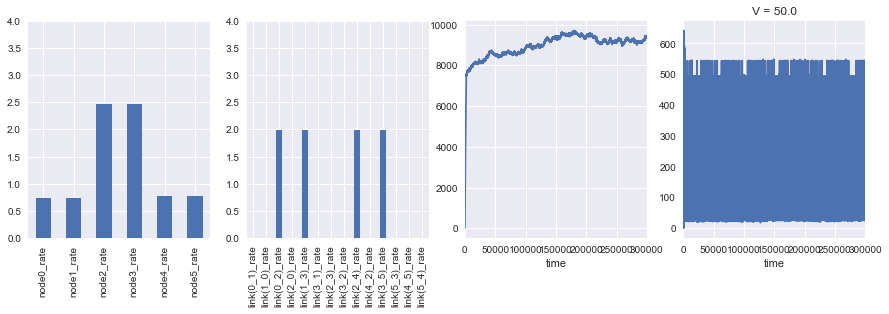

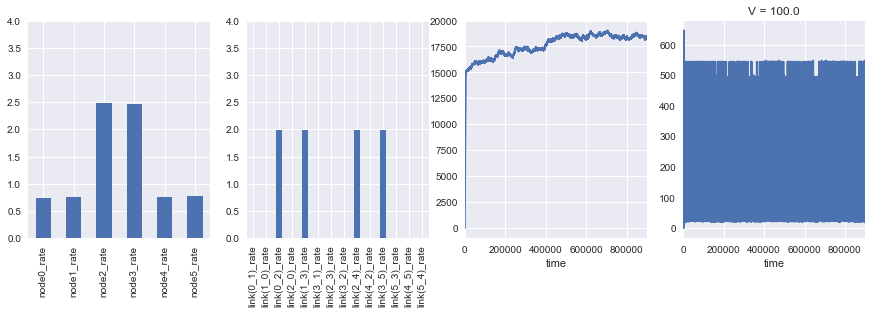

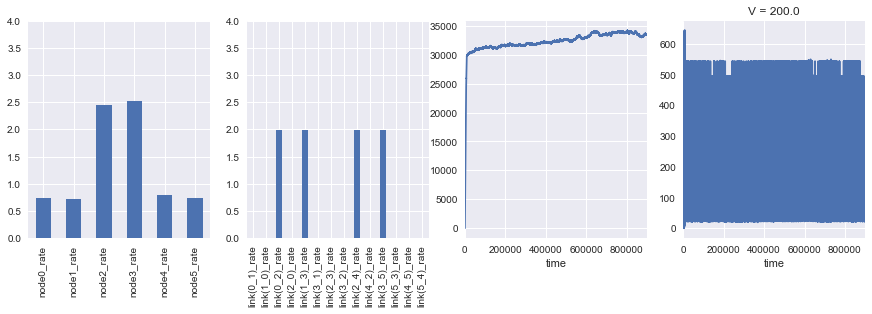

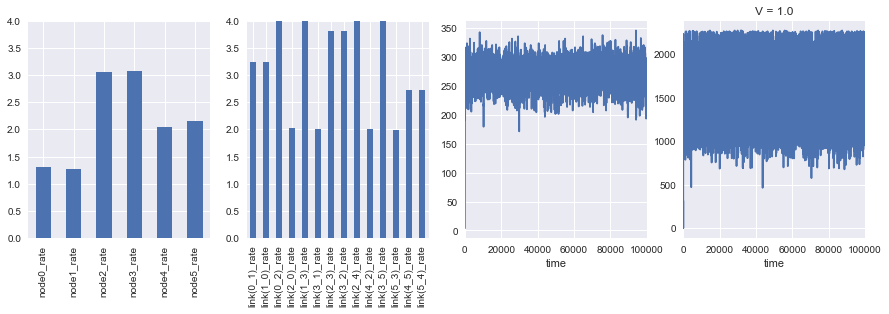

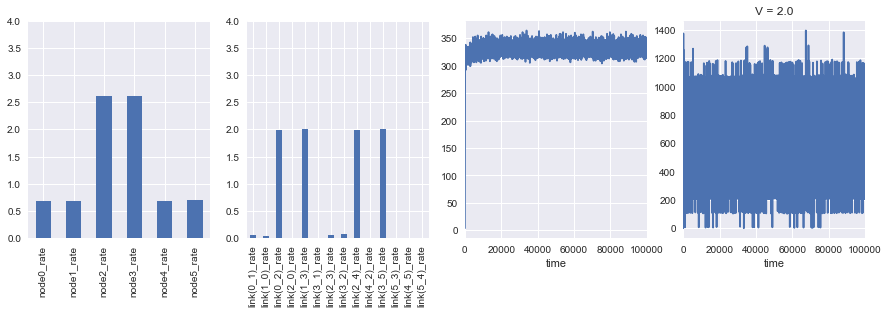

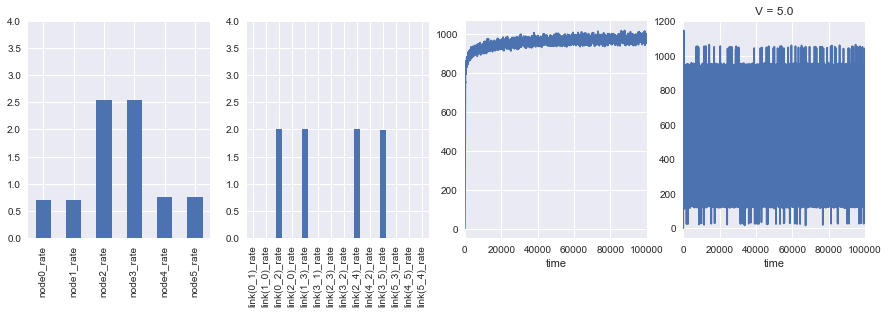

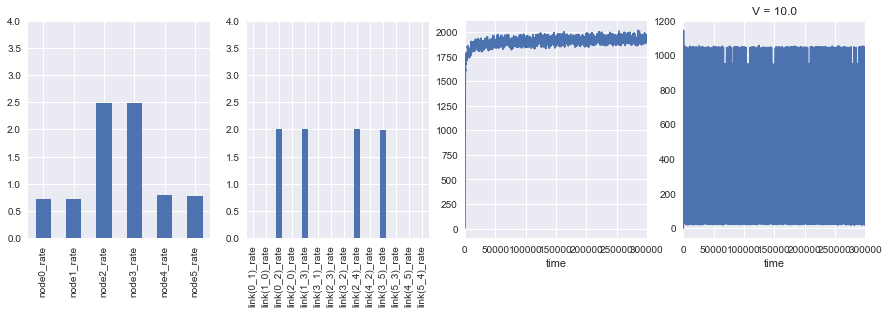

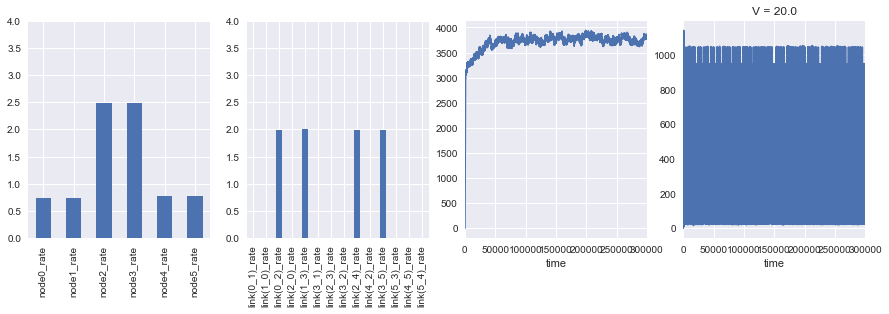

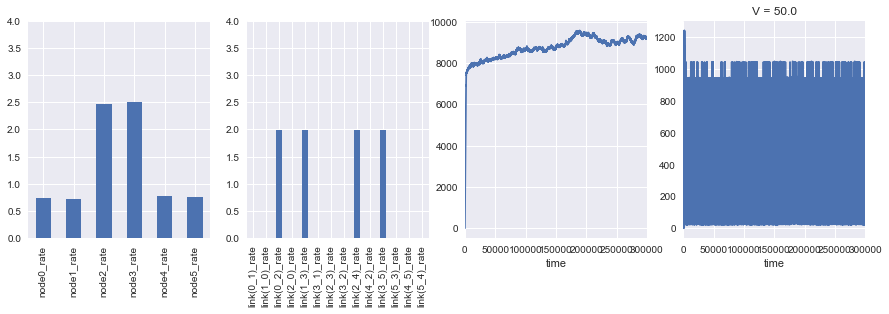

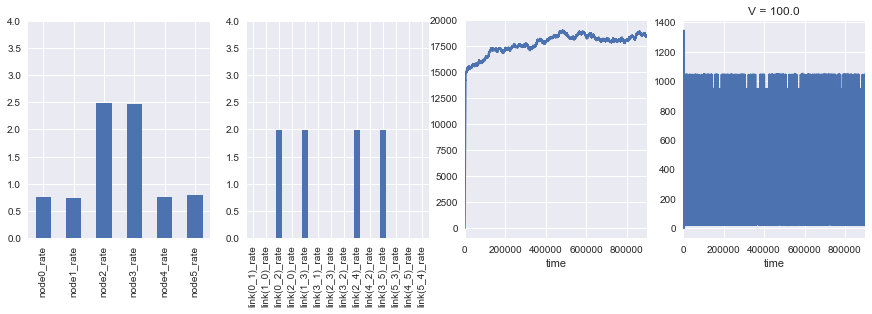

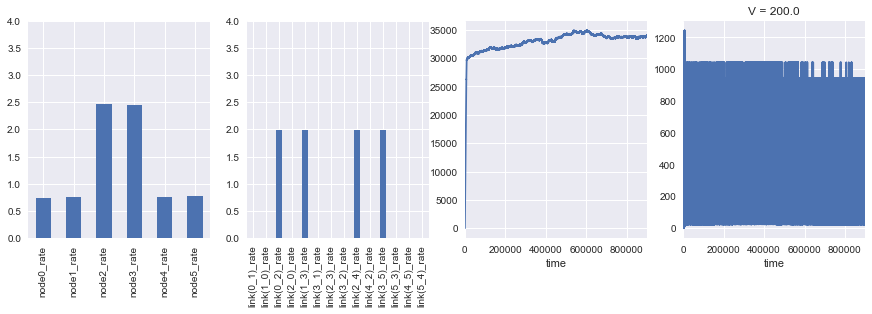

In [30]:
costrs = [0, 50, 100]
costr_costs = []
costr_queues = []
for costr in costrs:
    costs = []
    queues = []
    Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar, ', costr = ', costr
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1).mean())
        queues.append(queue.sum(axis=1).mean())
        del schedule, queue, cost
    
    costr_costs.append(costs)
    costr_queues.append(queues)

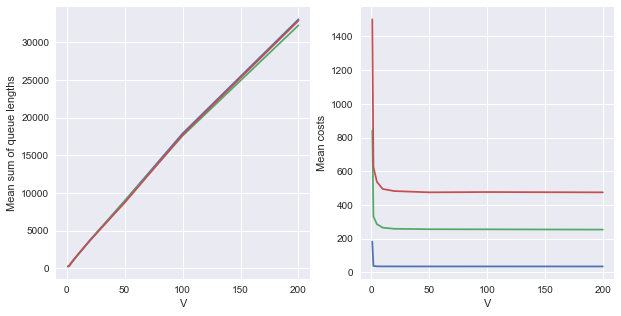

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for queues in costr_queues:
    plt.plot(Vs, queues)
    plt.xlabel('V')
    plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
for costs in costr_costs:
    plt.plot(Vs, costs)
    plt.xlabel('V')
    plt.ylabel('Mean costs')

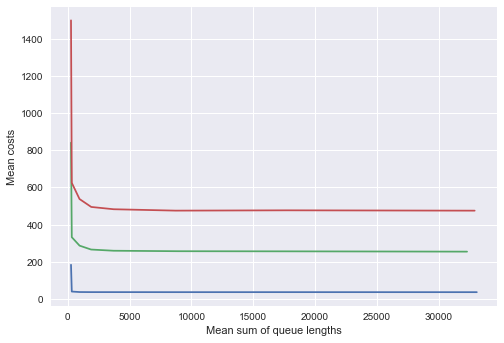

In [32]:
plt.figure()
for i in xrange(len(costrs)):
    plt.plot(costr_queues[i], costr_costs[i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')

In [38]:
data = {'costr_costs': costr_costs, 'costr_queues': costr_queues, 'costrs': costrs, 'Vs': Vs}

with open('output/reconfiguration_cost_delay_cost_DCNC.out', 'wb') as outFile:
    pickle.dump(data, outFile)

#### ADCNC

In [39]:
N = 6
t = 300000
deltar = 0
costr = 10
V = 10.0
policy = 'ADCNC'

In [ ]:
costrs = [0, 50, 100]
costr_costs = []
costr_queues = []
for costr in costrs:
    costs = []
    queues = []
    Vs = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
    for V in Vs:
        t = int(100000 * (3**(np.floor(np.log10(V)))))
        print 'V = ', V, ', deltar = ', deltar, ', costr = ', costr
        schedule, queue, cost = test(N, t, deltar, costr, policy, V)
        costs.append(cost.sum(axis=1).mean())
        queues.append(queue.sum(axis=1).mean())
        del schedule, queue, cost
    
    costr_costs.append(costs)
    costr_queues.append(queues)

V =  1.0 , deltar =  0 , costr =  0
Mean queue length sum =  241.428488889
Mean cost =  181.396533333
V =  2.0 , deltar =  0 , costr =  0
Mean queue length sum =  351.672844444
Mean cost =  40.0709444444
V =  5.0 , deltar =  0 , costr =  0
Mean queue length sum =  1036.6596
Mean cost =  36.7622777778
V =  10.0 , deltar =  0 , costr =  0
Mean queue length sum =  2381.04133704
Mean cost =  36.130762963
V =  20.0 , deltar =  0 , costr =  0
Mean queue length sum =  4766.54867407
Mean cost =  36.0477666667
V =  50.0 , deltar =  0 , costr =  0
Mean queue length sum =  10400.6571333
Mean cost =  35.9741185185
V =  100.0 , deltar =  0 , costr =  0


In [ ]:
plt.figure()
for i in xrange(len(costrs)):
    plt.plot(costr_queues[i], costr_costs[i])
    plt.xlabel('Mean sum of queue lengths')
    plt.ylabel('Mean costs')

In [ ]:
data = {'costr_costs': costr_costs, 'costr_queues': costr_queues, 'costrs': costrs, 'Vs': Vs}

with open('output/reconfiguration_cost_delay_cost_DCNC.out', 'wb') as outFile:
    pickle.dump(data, outFile)

### Processing and transmission rate for each commodity

We now analyze the previous simulation results to check the (processing/transmission) rate of each commodity at different nodes/links.

For each node/link, commodity 0 (shown in gray color in the bar plots) indicates the time portion that the node/link is in reconfiguration.

In [107]:
def rate_plot(schedule, cost, V):
    # merge schedule and cost data
    cost.columns = [x+'_cost' for x in cost.columns]
    schedule = schedule.join(cost, how='inner')
    
    node_rates = pd.DataFrame()
    node_costs = pd.DataFrame()
    for n in xrange(N):
        node = schedule.columns[['node'+str(n) in x for x in schedule.columns]]
        df = schedule[node].copy()
        # Set the scheduled packet as NaN when in reconfiguration
        df.loc[df['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_packet'] = None
        # Set the process cost as 0 when in reconfiguration
        df.loc[df['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_px_cost'] = 0
        # Sum up the process and allocation cost
        df['node'+str(n)+'_cost'] = df['node'+str(n)+'_px_cost'] + df['node'+str(n)+'_resource_cost']
        df = df.fillna(0)
        df_rate = (df.groupby('node'+str(n)+'_packet').sum() / df.shape[0])[['node'+str(n)+'_rate']]
        df_rate.index.name = ''
        df_cost = (df.groupby('node'+str(n)+'_packet').sum() / df.shape[0])[['node'+str(n)+'_cost']]
        df_cost.index.name = ''

        if node_rates.empty:
            node_rates = df_rate
            node_costs = df_cost
        else:
            node_rates = node_rates.join(df_rate, how='outer')
            node_costs = node_costs.join(df_cost, how='outer')

    node_rates = node_rates.sort_index(ascending=False)
    node_rates = node_rates.stack()
    node_rates = node_rates.unstack(0)
    node_costs = node_costs.sort_index(ascending=False)
    node_costs = node_costs.stack()
    node_costs = node_costs.unstack(0)
    
    link_rates = pd.DataFrame()
    link_costs = pd.DataFrame()
    for l in schedule.columns[['link' in x and 'rate' in x for x in schedule.columns]].str.strip('_rate'):
        link = schedule.columns[[l in x for x in schedule.columns]]
        df = schedule[link].copy()
        # Set the scheduled packet as NaN when in reconfiguration
        df.loc[df[l+'_reconfig'] > 0, l+'_packet'] = None
        # Set the transmission cost as 0 when in reconfiguration
        df.loc[df[l+'_reconfig'] > 0, l+'_tx_cost'] = 0
        # Sum up the transmission and allocation cost
        df[l+'_cost'] = df[l+'_tx_cost'] + df[l+'_resource_cost']
        df = df.fillna(0)
        df_rate = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_rate']]
        df_rate.index.name = ''
        df_cost = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_cost']]
        df_cost.index.name = ''
        if link_rates.empty:
            link_rates = df_rate
            link_costs = df_cost
        else:
            link_rates = link_rates.join(df_rate, how='outer')
            link_costs = link_costs.join(df_cost, how='outer')

    link_rates = link_rates.sort_index(ascending=False)
    link_rates = link_rates.stack()
    link_rates = link_rates.unstack(0)
    link_costs = link_costs.sort_index(ascending=False)
    link_costs = link_costs.stack()
    link_costs = link_costs.unstack(0)
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    fig.tight_layout(pad=6.0)
    node_rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[0], colormap='nipy_spectral')
    axes[0].set_title('V = ' + str(V))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    link_rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[1], colormap='nipy_spectral')
    axes[1].set_title('V = ' + str(V))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    node_costs.plot(kind='bar', stacked=True, ax=axes[2], colormap='nipy_spectral')
    axes[2].set_title('V = ' + str(V))
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    link_costs.plot(kind='bar', stacked=True, ax=axes[3], colormap='nipy_spectral')
    axes[3].set_title('V = ' + str(V))
    axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

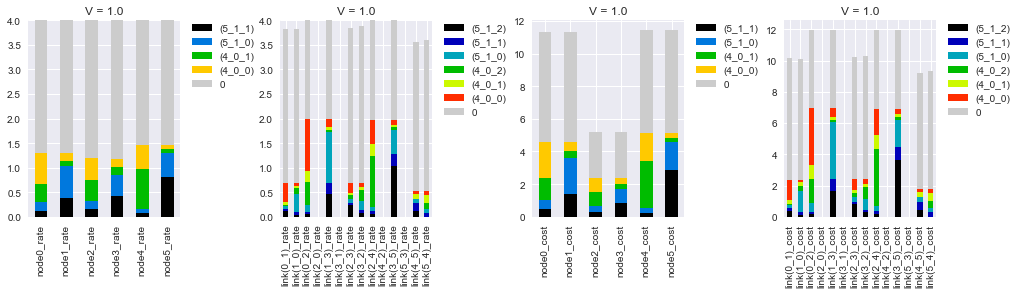

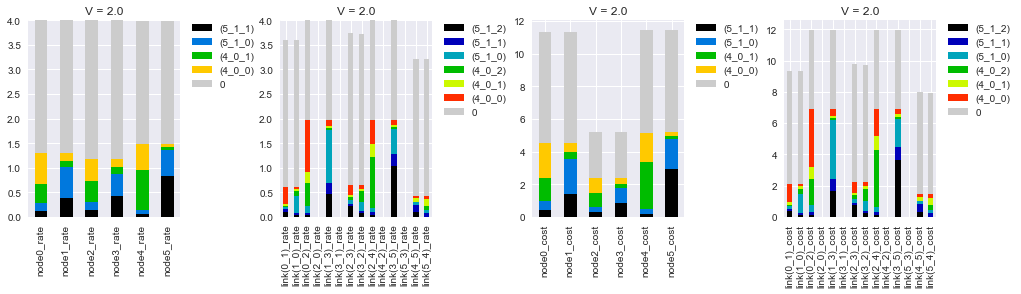

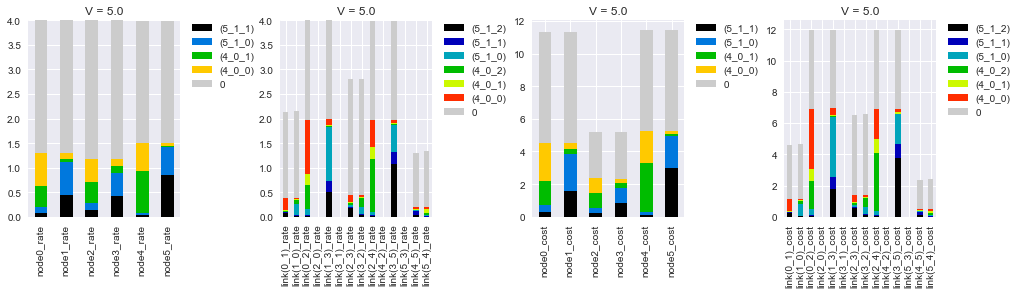

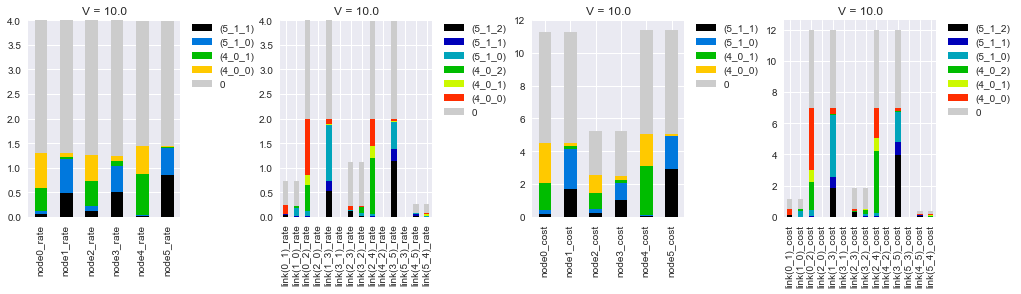

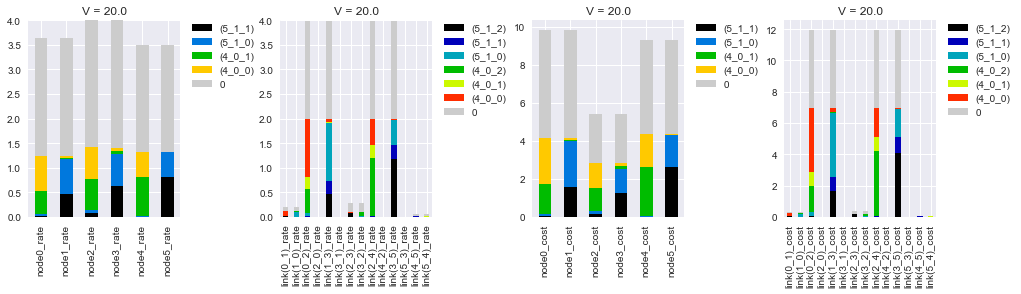

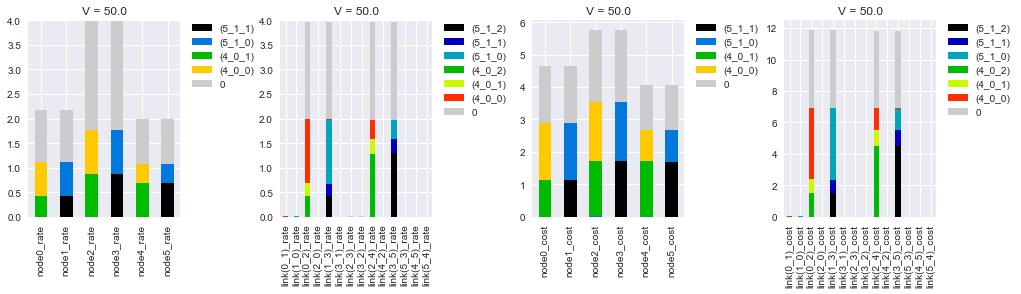

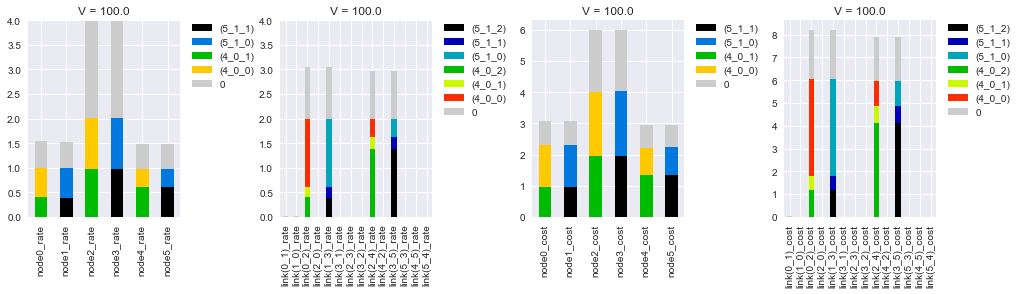

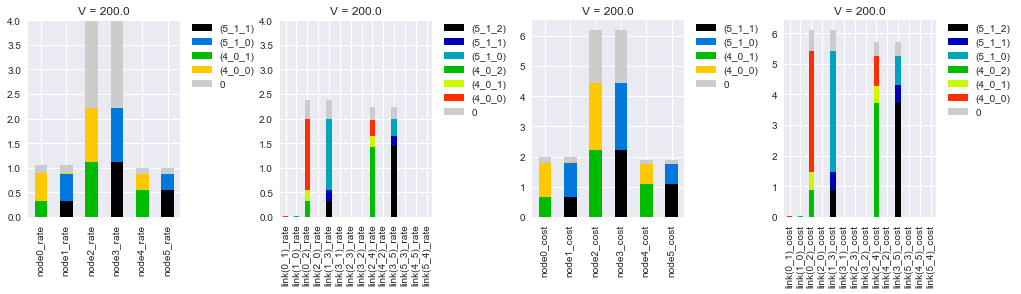

In [10]:
for V in Vs:
    t = int(100000 * (3**(np.floor(np.log10(V)))))
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    cost = pd.DataFrame.from_csv(output_dir + 'cost_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, cost, V)

In the bar plots above, the gray area indicate the portion when one resource is in reconfiguration. In other words, during these portion, the resource is allocated but is not processing/transmitting due to reconfiguration delay.

Comparing the results under different parameter V, we may observe that larger V parameter induces less variation in the route selection and the NFV location, and in turn reduces the overhead wasted to reconfiguration. However, this is at the expense of larger queue length (delay), as indicated in the cost-delay tradeoff shown above.

## DCNC with various parameter V

In [14]:
N = 6
t = 1000000
deltar = 10
policy = 'DCNC'
V = 1.0

V =  1.0
Mean queue length sum =  230121.389447
Mean cost =  157.601822222
V =  5.0
Mean queue length sum =  218728.310964
Mean cost =  124.081498889
V =  10.0
Mean queue length sum =  222312.98228
Mean cost =  113.909954444
V =  50.0
Mean queue length sum =  219972.859383
Mean cost =  107.26372
V =  100.0
Mean queue length sum =  226028.46661
Mean cost =  107.268193333


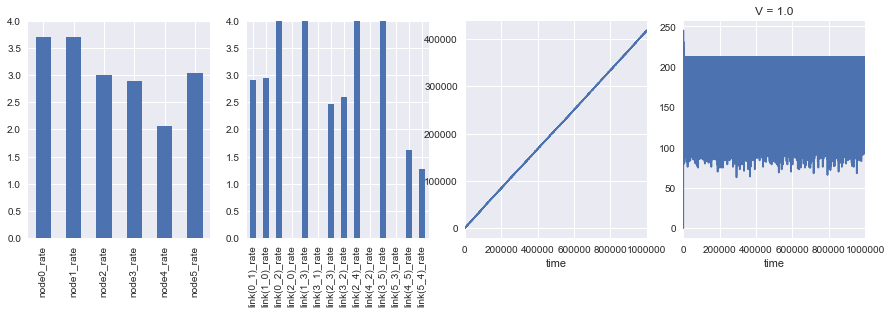

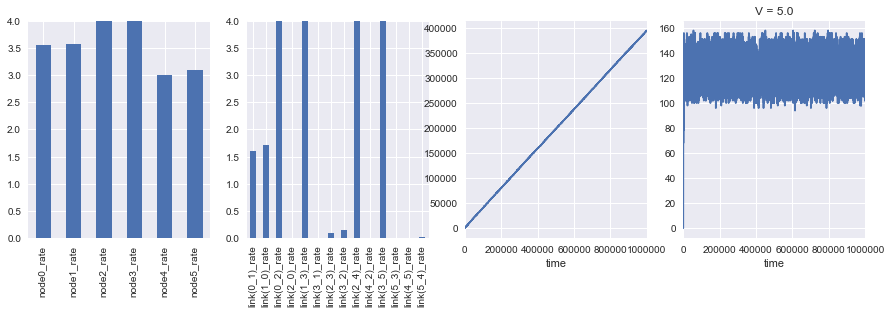

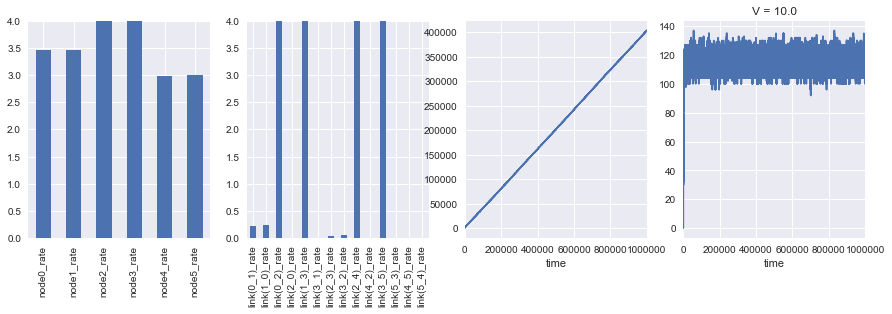

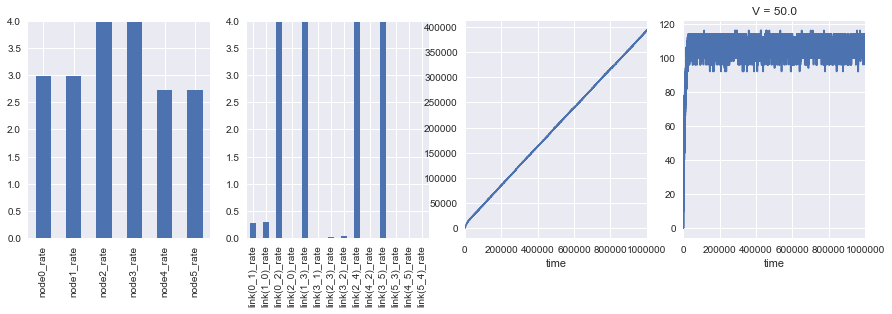

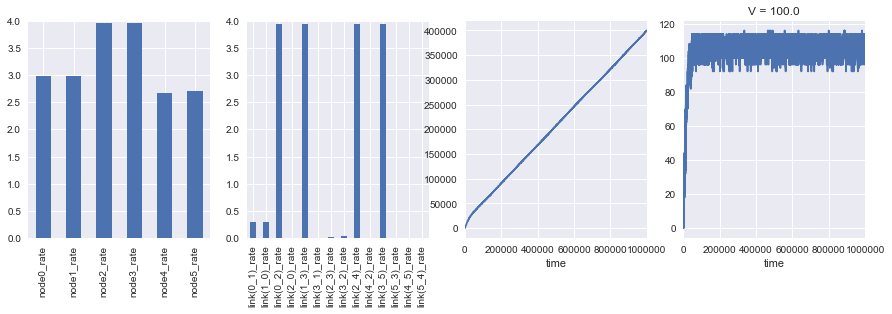

In [15]:
costs = []
queues = []
Vs = [1.0, 5.0, 10.0, 50.0, 100.0]
for V in Vs:
    print 'V = ', V
    schedule, queue, cost = test(N, t, deltar, policy, V)
    costs.append(cost.sum(axis=1).mean())
    queues.append(queue.sum(axis=1).mean())
    del schedule, queue, cost

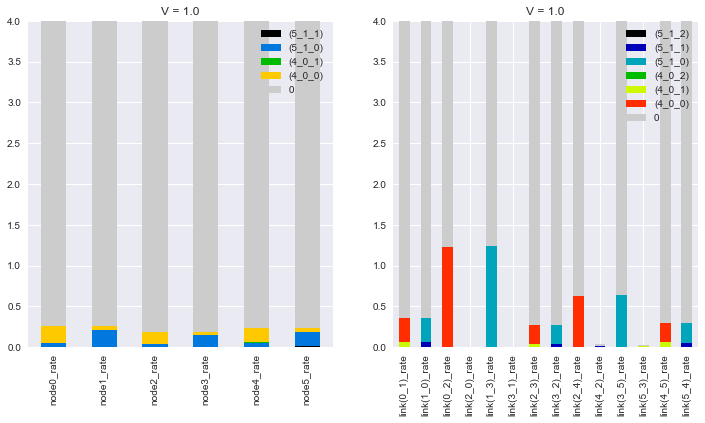

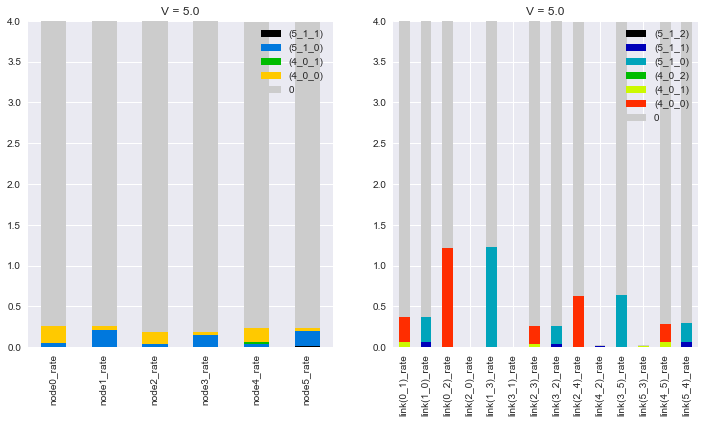

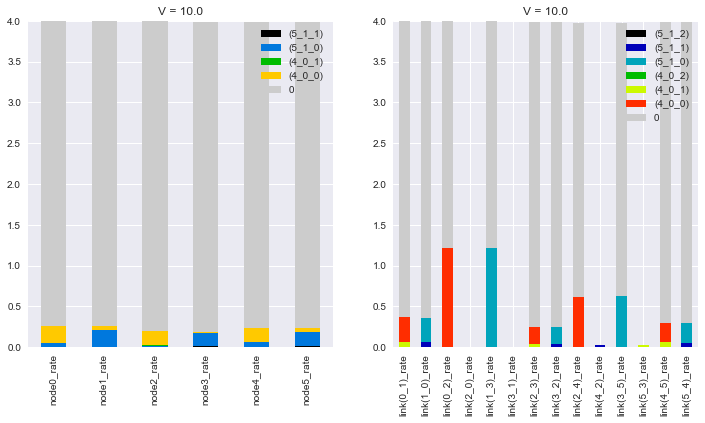

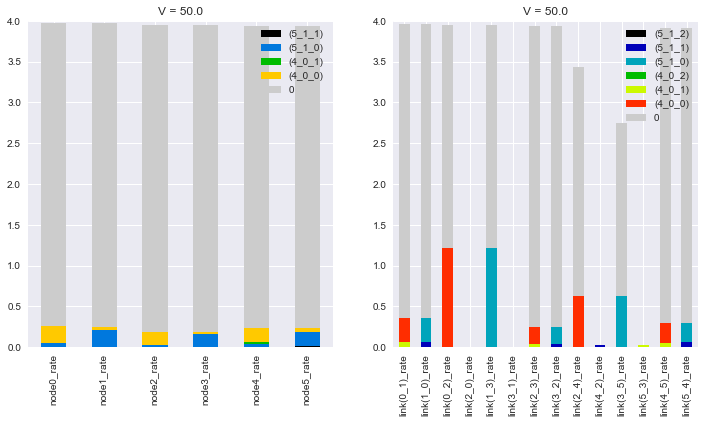

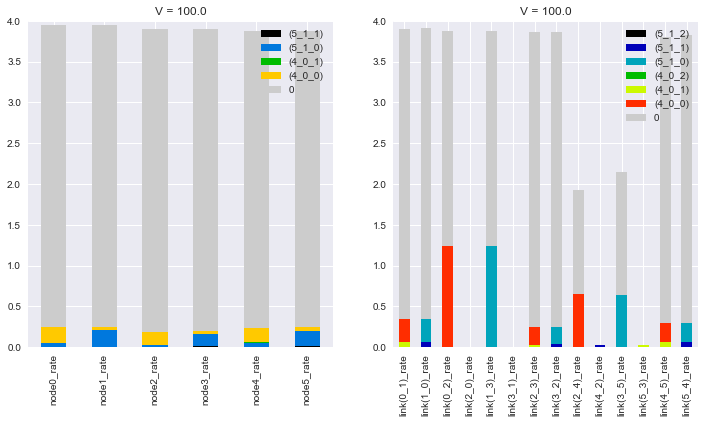

In [23]:
for V in Vs:
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, V)

## Comparison with DCNC under no reconfiguration delay

Reconfiguration delay $\Delta_r = 0$

In [24]:
N = 6
t = 100000
deltar = 0
policy = 'DCNC'
V = 1.0

V =  1.0
Mean queue length sum =  287.902811111
Mean cost =  190.722833333
V =  5.0
Mean queue length sum =  1160.38832222
Mean cost =  38.2032444444
V =  10.0
Mean queue length sum =  2273.16604444
Mean cost =  37.9792777778
V =  50.0
Mean queue length sum =  10021.8512556
Mean cost =  37.8277333333
V =  100.0
Mean queue length sum =  19552.1407111
Mean cost =  37.9407555556


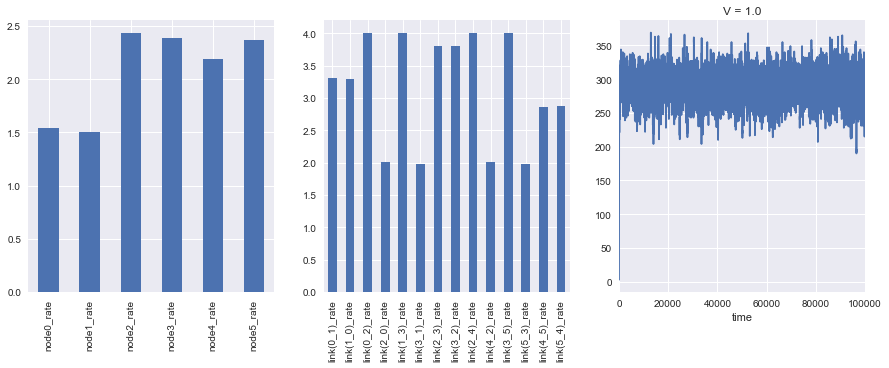

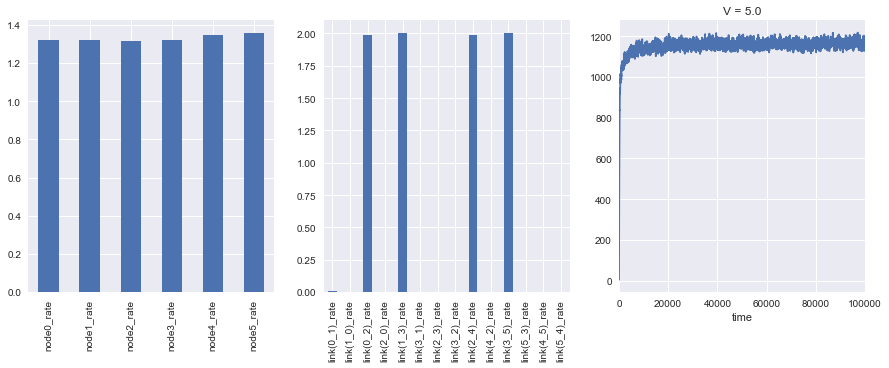

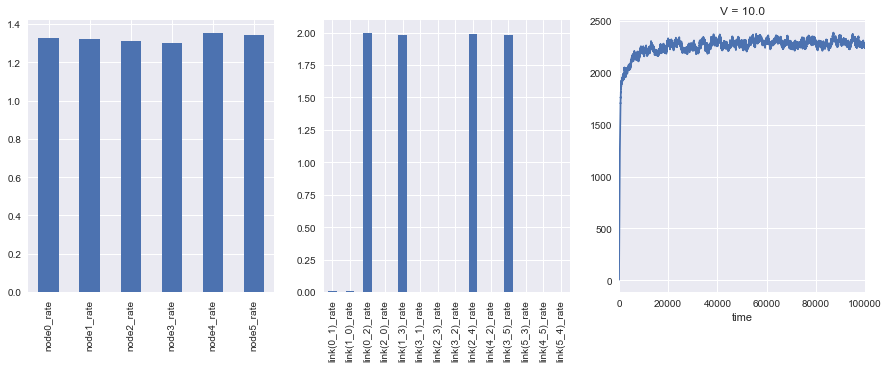

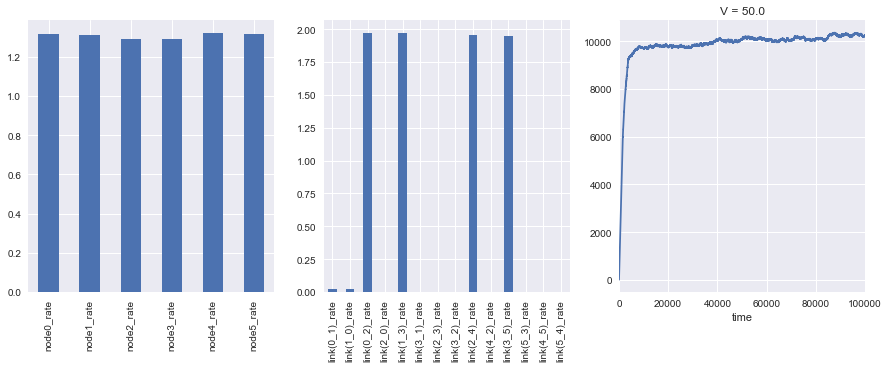

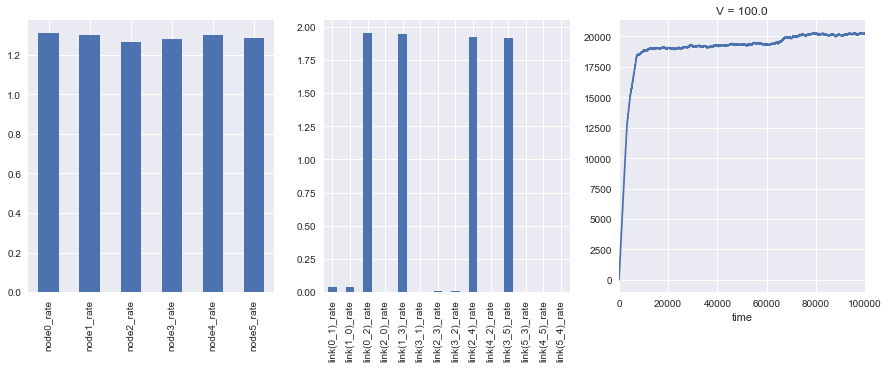

In [25]:
costs = []
queues = []
Vs = [1.0, 5.0, 10.0, 50.0, 100.0]
for V in Vs:
    print 'V = ', V
    schedule, queue, cost = test(N, t, deltar, policy, V)
    costs.append(cost.sum(axis=1).mean())
    queues.append(queue.sum(axis=1).mean())
    del schedule, queue, cost

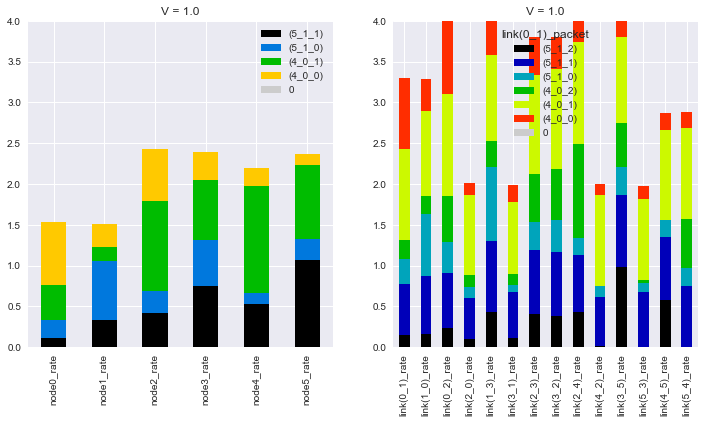

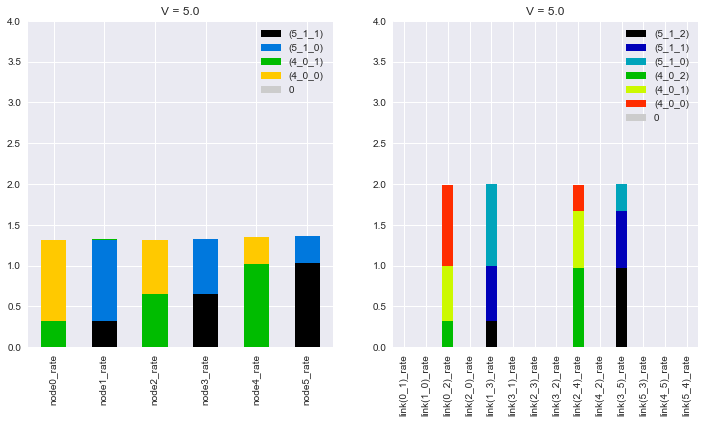

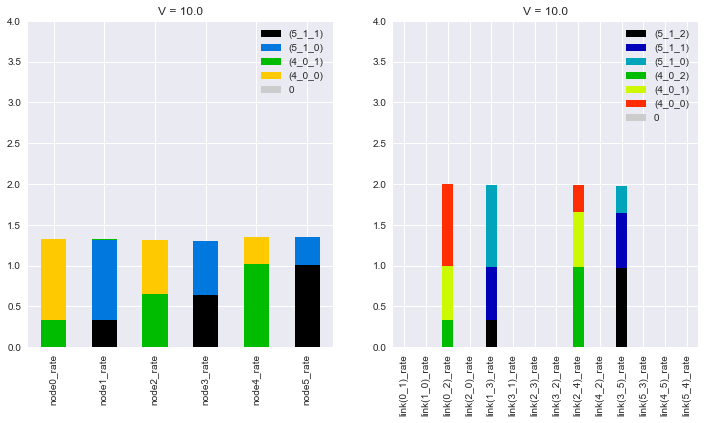

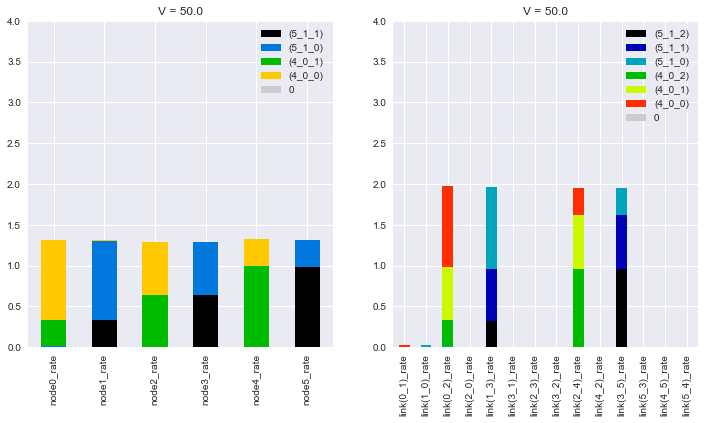

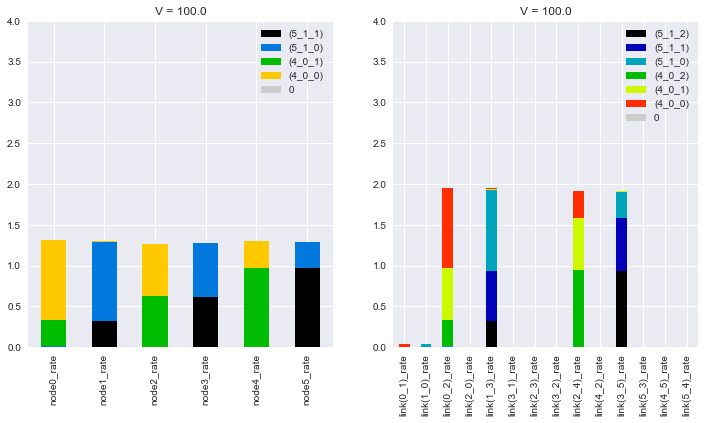

In [27]:
for V in Vs:
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, V)